In [1]:
import re
import numpy as np
import itertools
import os
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim
from torch.utils.data import random_split, RandomSampler
import random 
import matplotlib.pyplot as plt
from utils import *
from model_v1 import feed_forward
from scipy.stats import gaussian_kde


In [2]:
def plot_mean_with_errorbars(t_values, x_values, window_size, interval,color,plt,label):
    # Calculate the mean and standard deviation
    x_mean = [np.mean(x_values[max(0, i - window_size + 1):i + 1]) for i in range(len(t_values))]
    x_std = [np.std(x_values[max(0, i - window_size + 1):i + 1]) for i in range(len(t_values))]

    # Create the plot
    plt.plot(t_values, x_mean, linestyle='-',color=color,label=label)
    
    
    plt.errorbar(t_values, x_mean, yerr=x_std,alpha=0.02,color=color)
    
    plt.legend()
    plt.grid(True)
    #plt.show()
    
def plot_bar(x,plot_save_path,title=r'$E_{DFT}-E_{ff} \quad vs \quad E_{delta-ml}$'):
    plt.figure(figsize=(4,3),dpi=300)
    #average_maeloss = np.sum(x,axis=0)/len(x)
    
    average_maeloss = np.mean(x, axis=0)
    std_maeloss = np.std(x, axis=0)
    
    label = ['cls_elec','ct','mod_pauli','pol','disp']
    plt.bar(label, average_maeloss,yerr=std_maeloss, capsize=5, align='center', alpha=0.7)
    plt.ylabel('Mae')
    plt.title(title)
    
    plt.tight_layout()
    plt.savefig(plot_save_path+ele+'_maebar.jpg')
    plt.show()
    
    
# scatter plot E_deltaml vs E_real
def plot_scatter(x,y,plot_save_path,title):
    # x : E_eda - E_ff
    # y : E_ml
    fig, ax = plt.subplots(1, 1, figsize = (3, 3), dpi = 300) 
    #ax.figure(figsize=(3,3),dpi=200)
    
    ax.scatter(x,y,s=3,alpha = 0.7, zorder=10)
    
    ax.axis('equal')
    x_ticks = ax.get_yticks()
    #ax.set_xticks(x_ticks)
    #ax.set_xticklabels(x_ticks, rotation=90)
    #ax.set_yticks(x_ticks)
    ax.plot(x_ticks,x_ticks,zorder=0, linestyle='dotted',color = 'grey')
    ax.set_xlabel(r'$E_{DFT}-E_{ff}$(kJ/mol)')
    ax.set_ylabel(r'$E_{delta-ml}$(kJ/mol)')
    ax.set_title(title)
    ax.grid(True)
    plt.tight_layout()
    plt.savefig(plot_save_path+title+'.jpg')
    plt.show()
    
# box plot of the errors
def plot_box(x, plot_save_path,ele,labeltype):
    plt.figure(figsize=(4, 3), dpi=300)
    
    label = ['cls_elec', 'ct', 'mod_pauli', 'pol', 'disp']
    title=ele+'_'+r'$E_{DFT}-E_{ff} \quad vs \quad E_{delta-ml}$'
    plt.boxplot(x, labels=label,showfliers=False)
    plt.ylabel('error(kJ/mol)')
    plt.title(title)
    
    plt.tight_layout()
    plt.savefig(plot_save_path + ele+'_'+labeltype+'_errorbox.jpg')
    plt.show()

# eda-aniso

br


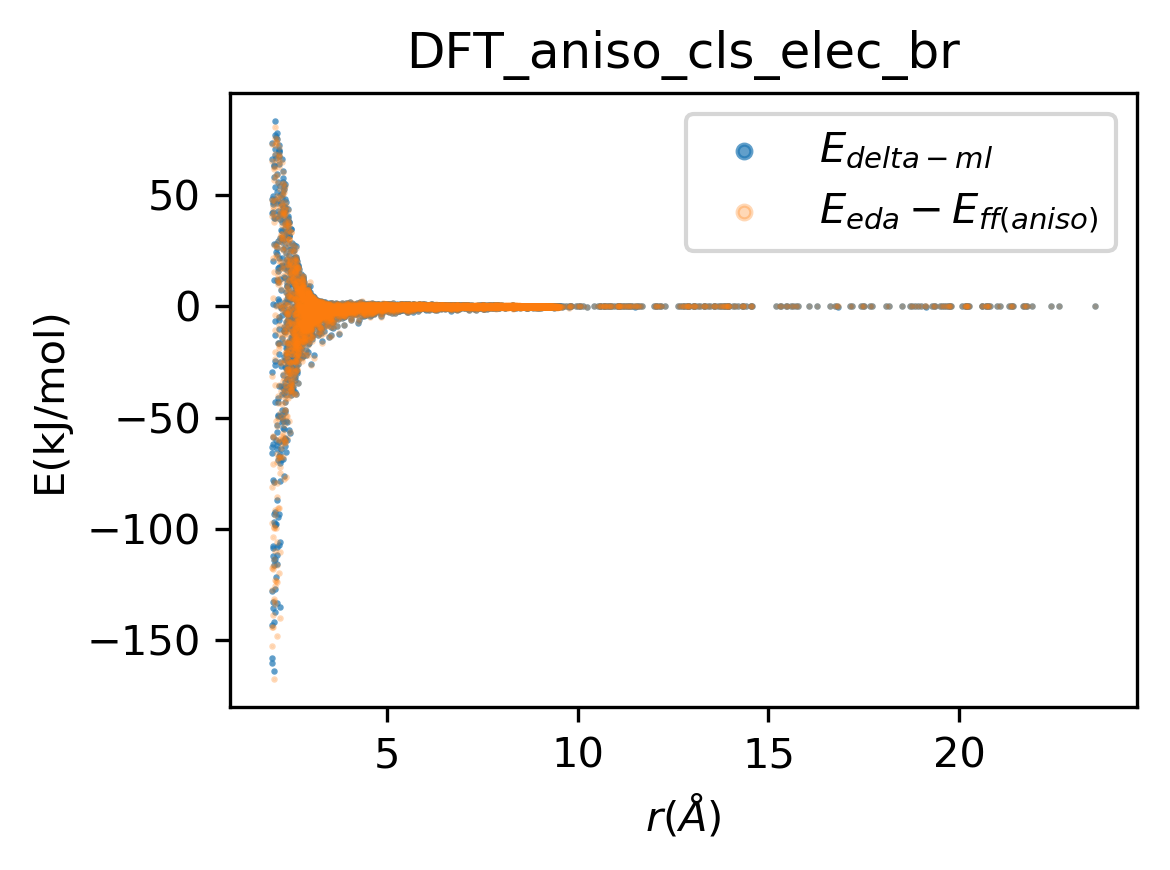

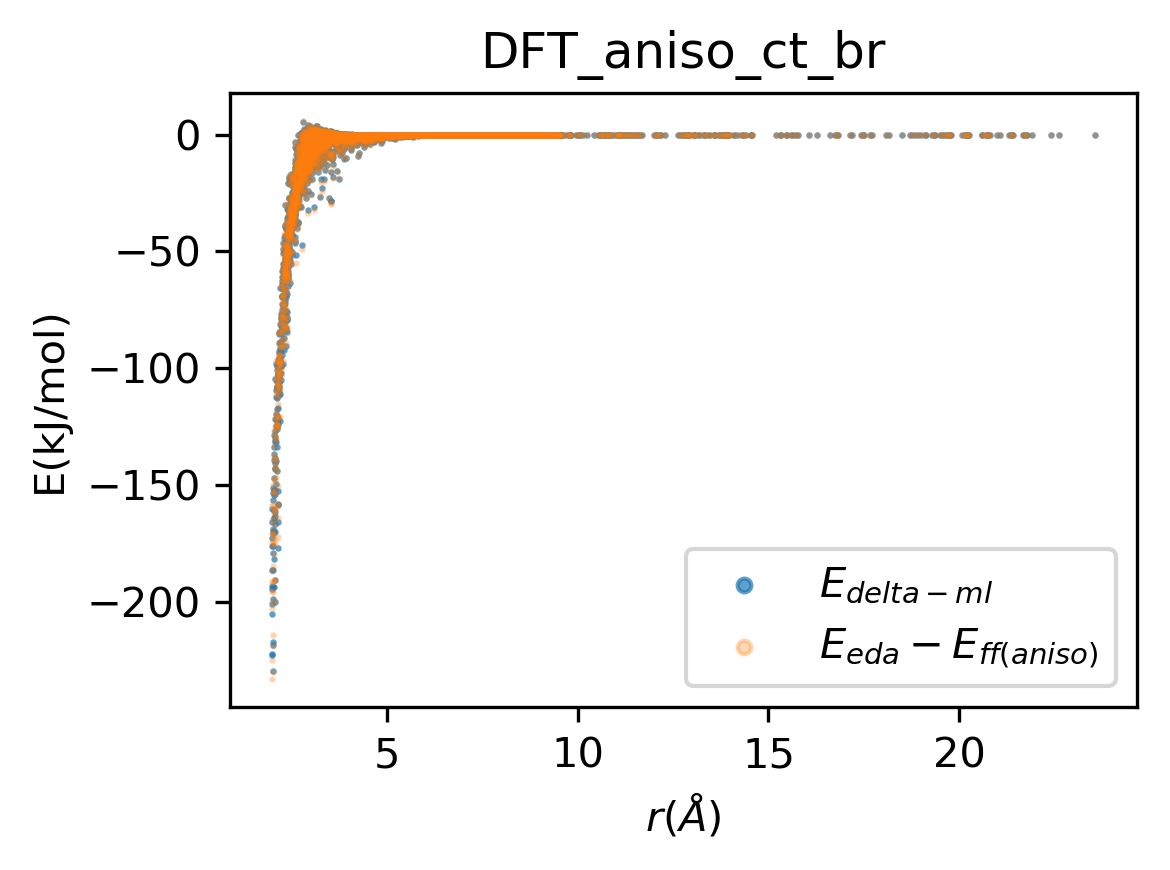

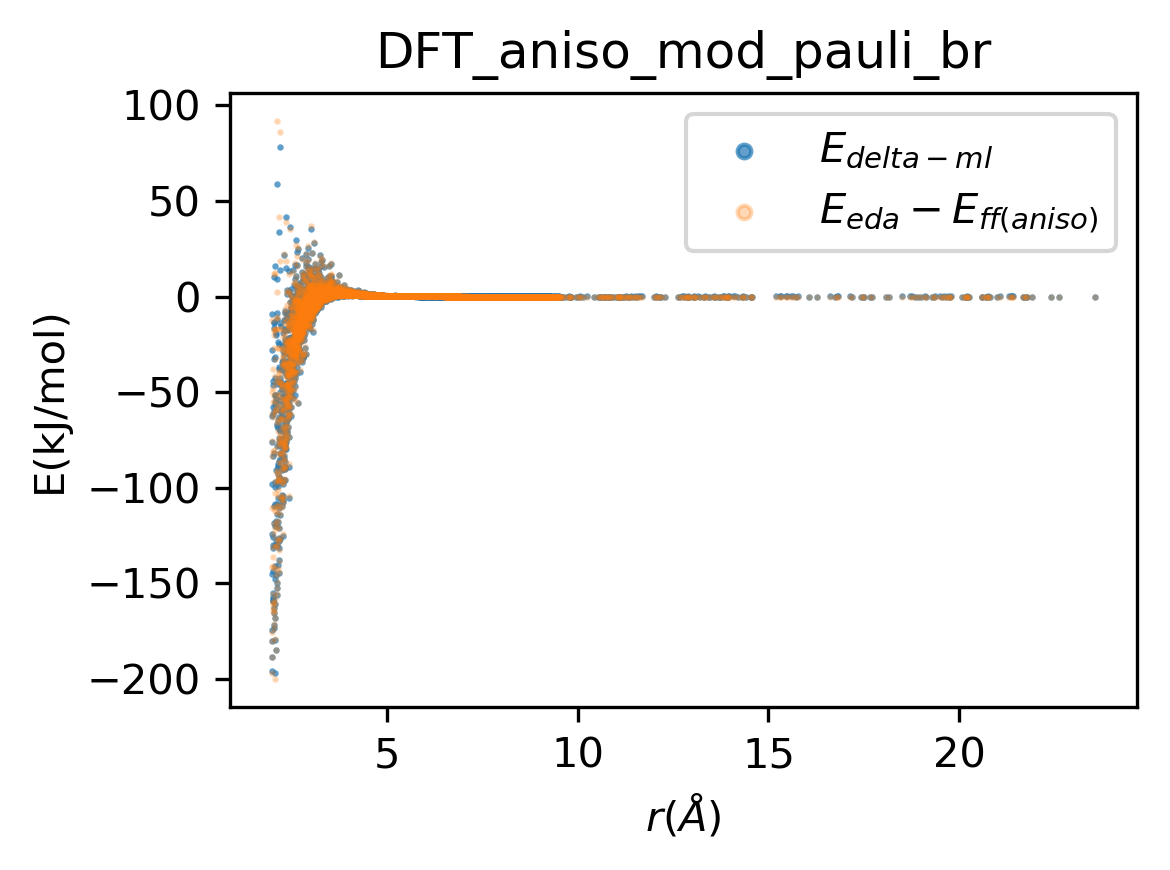

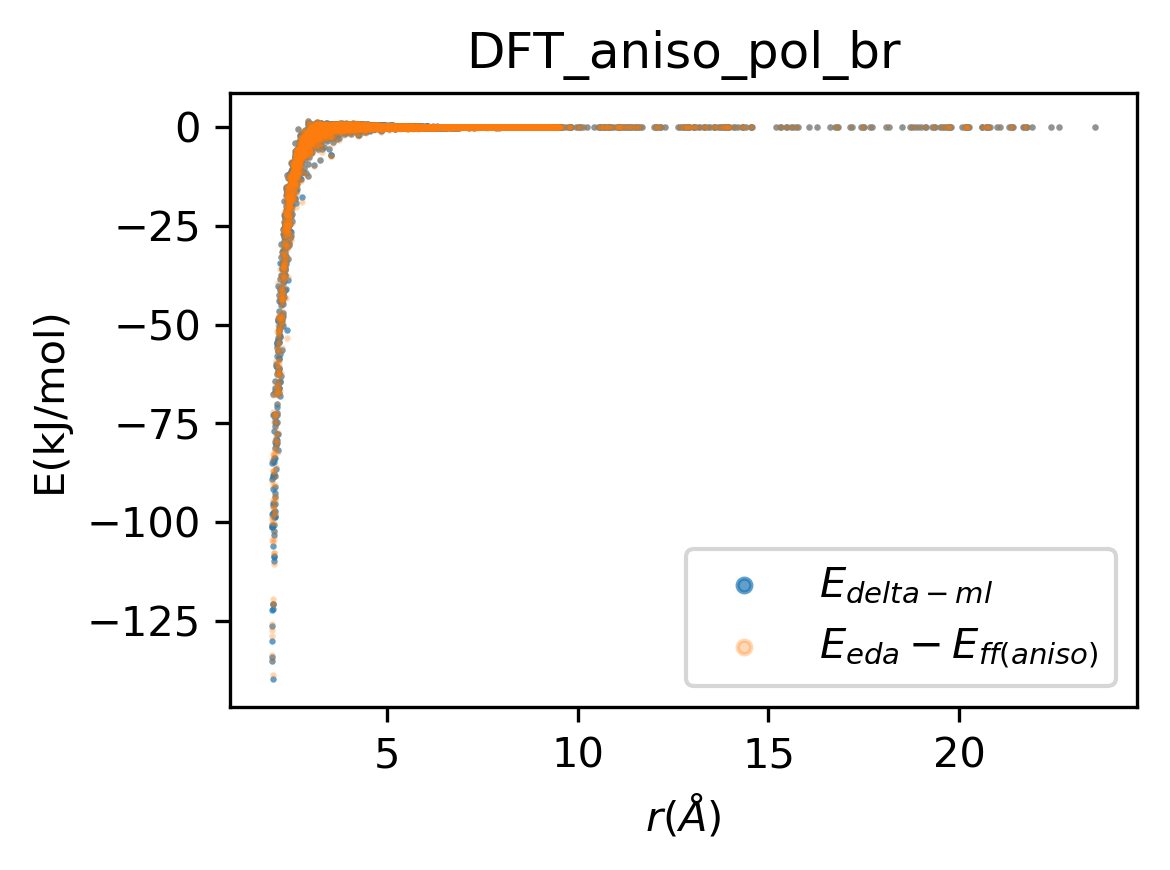

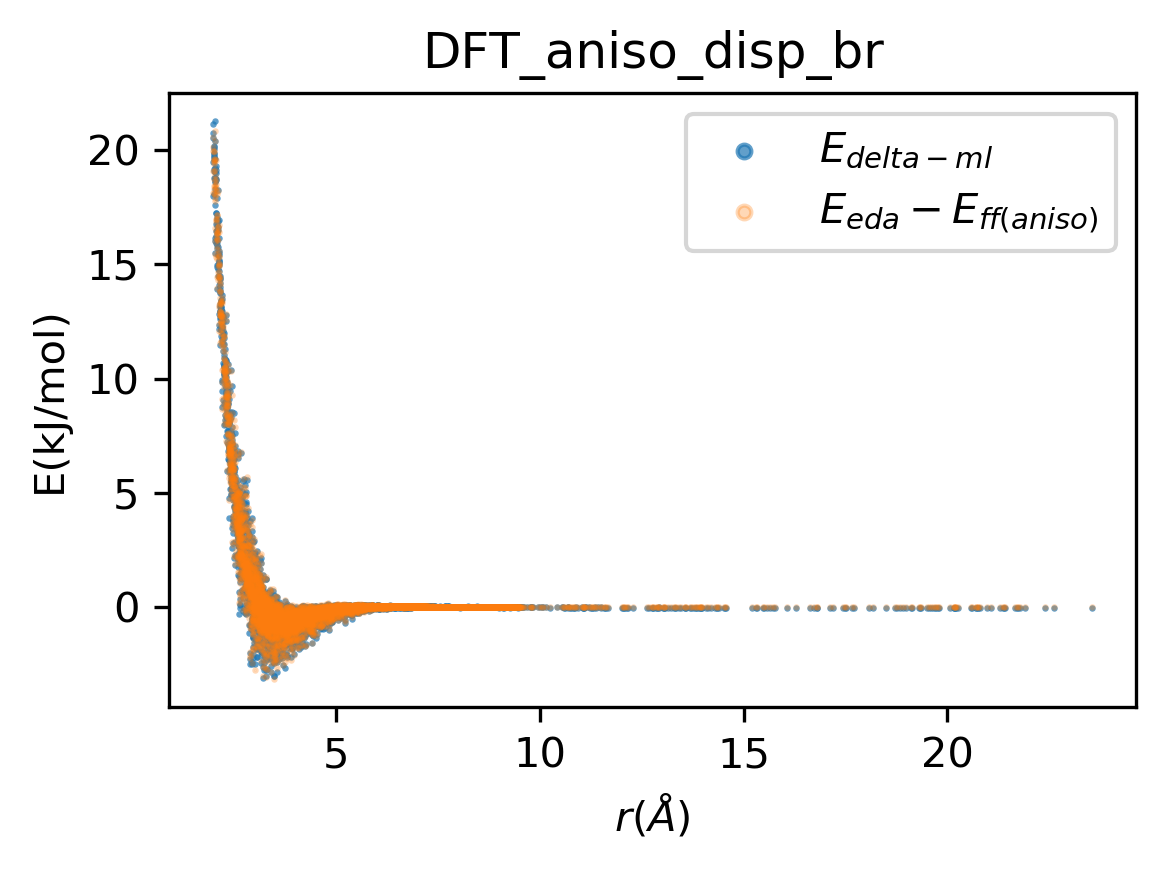

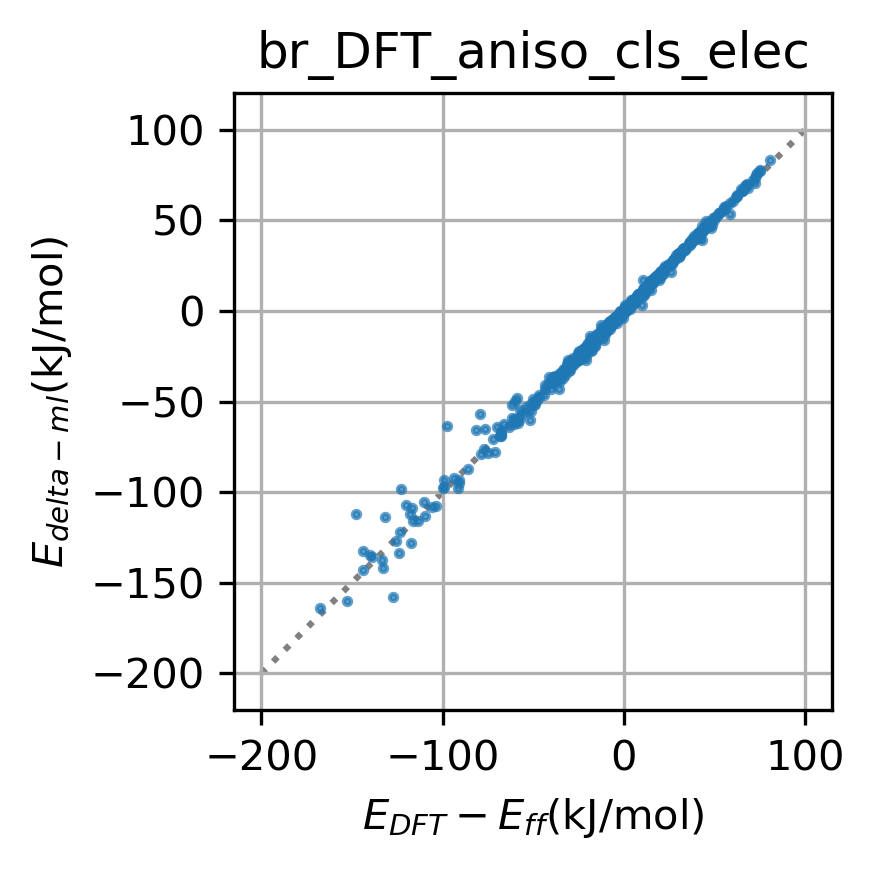

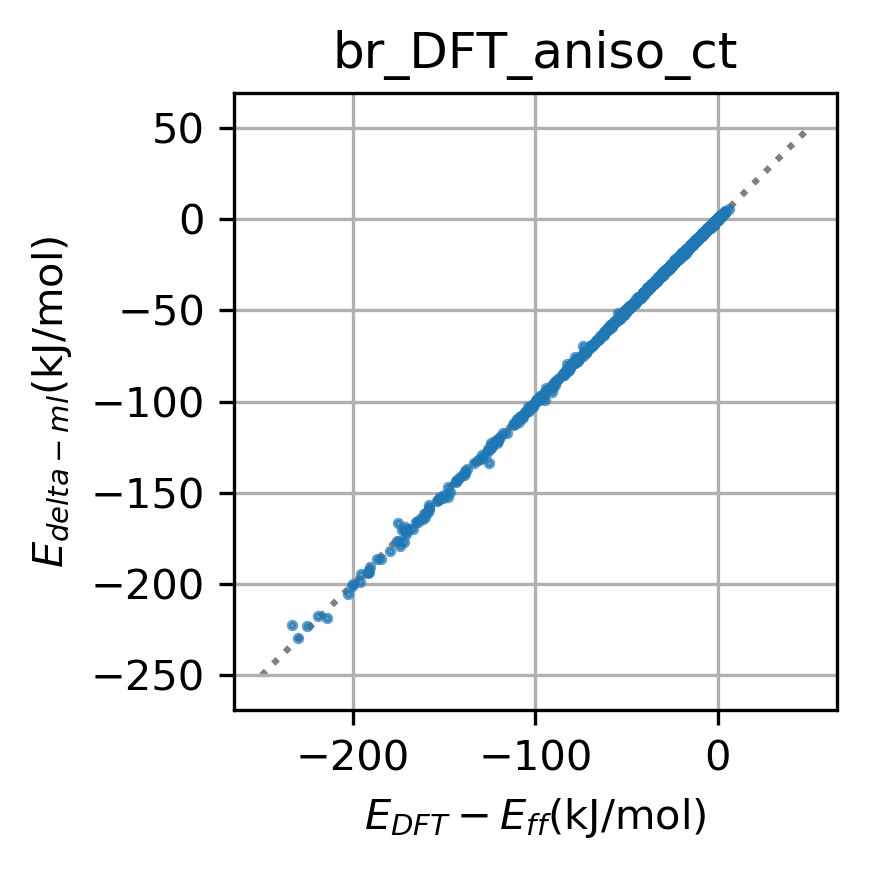

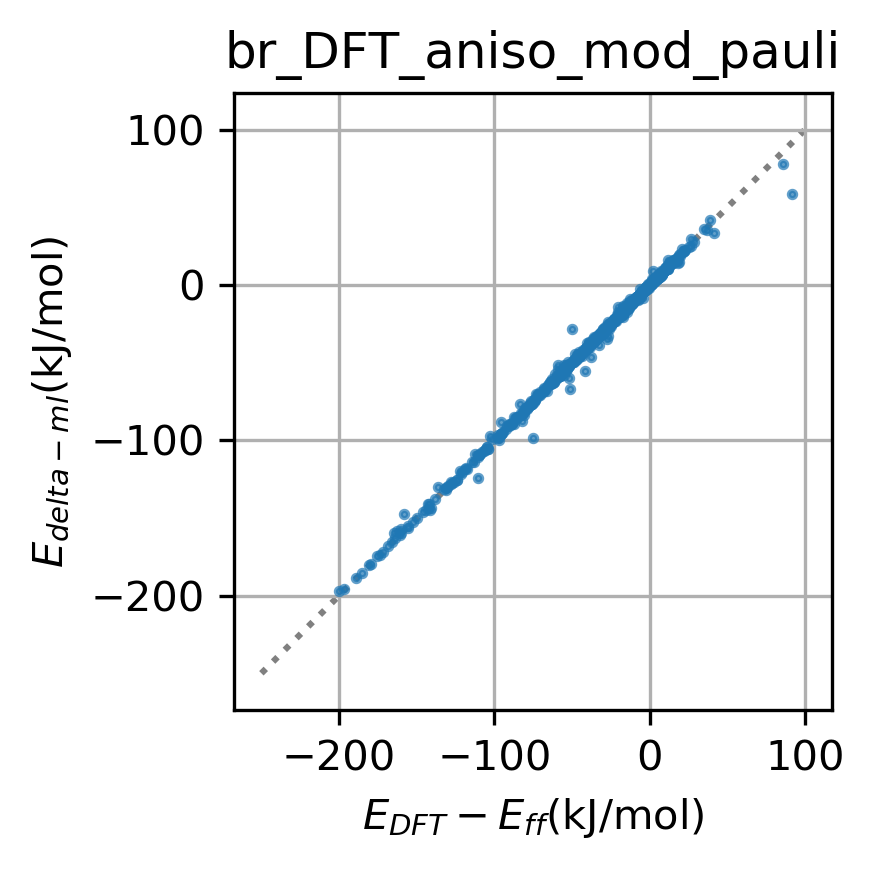

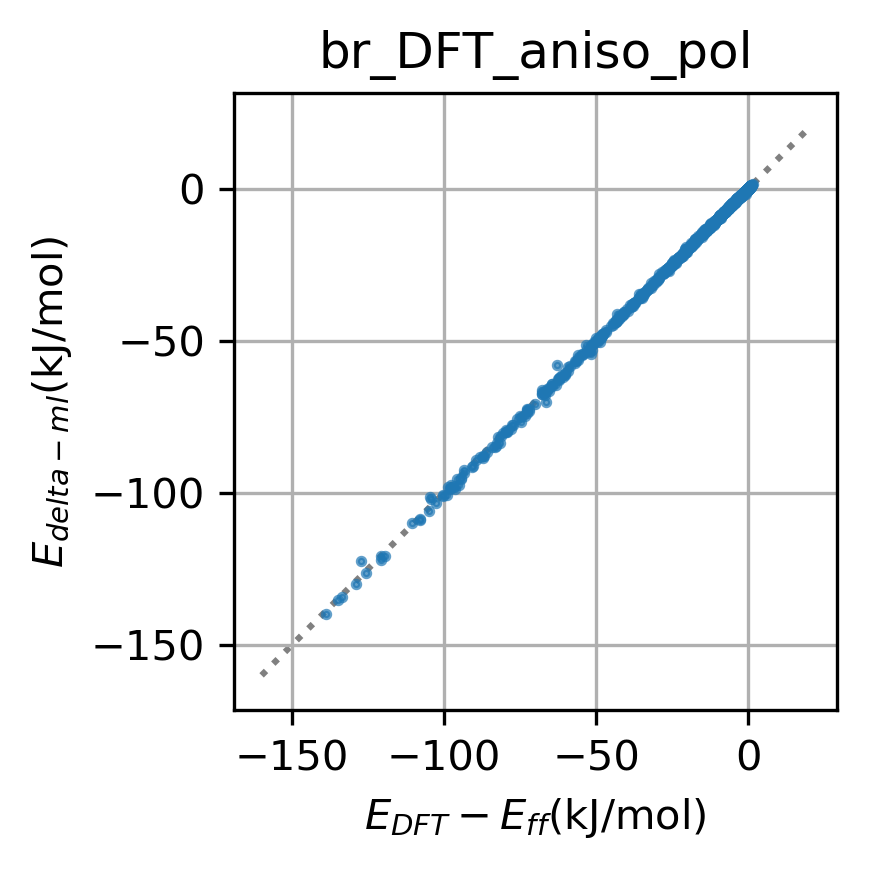

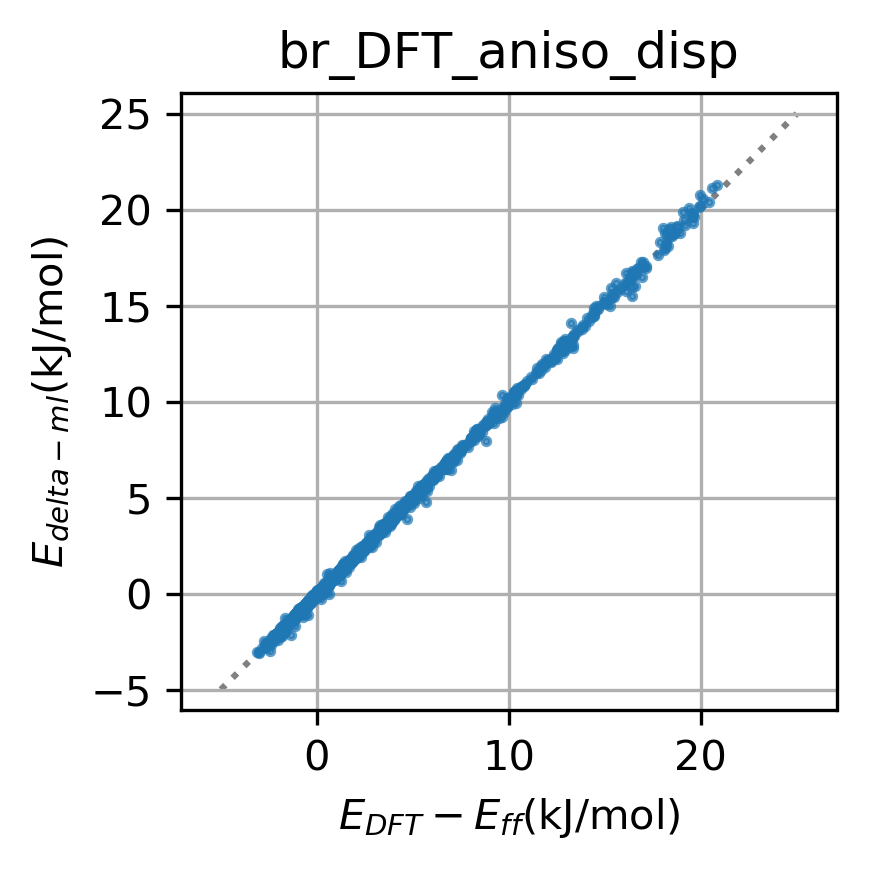

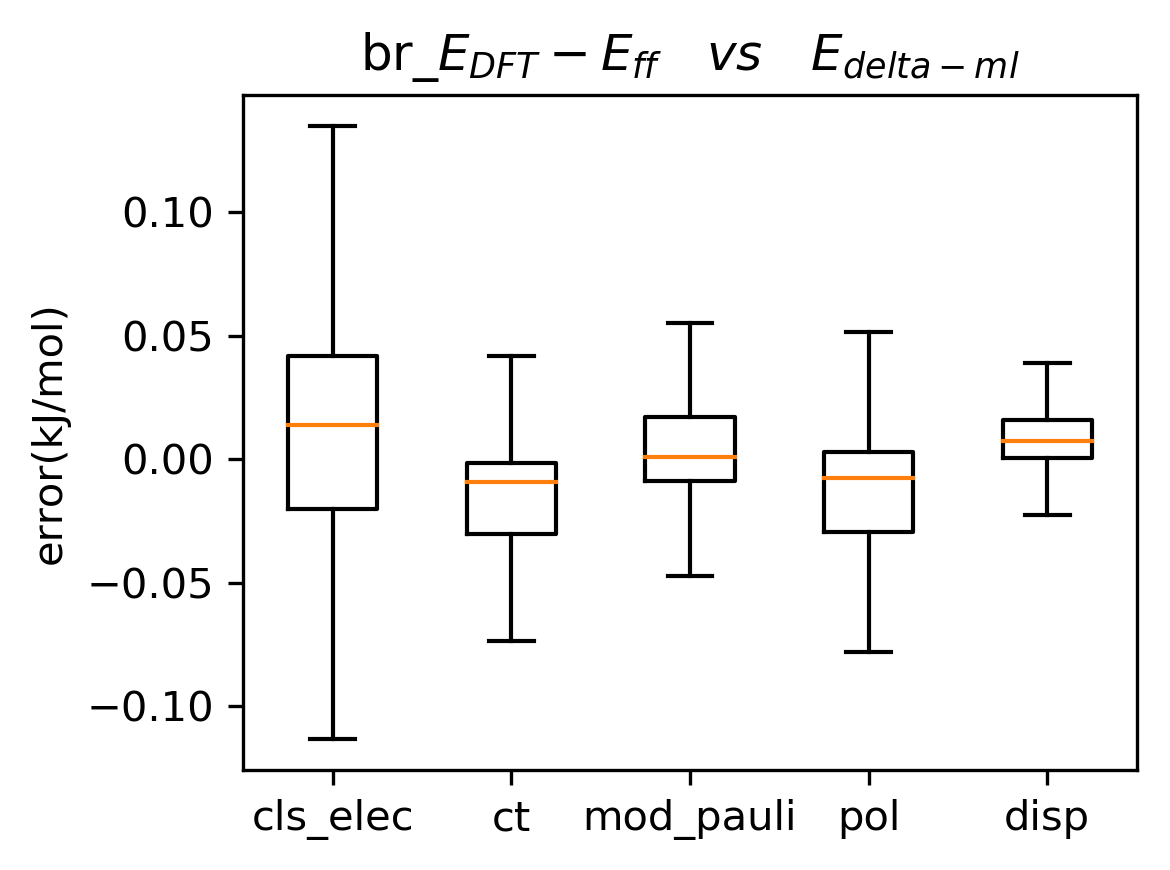

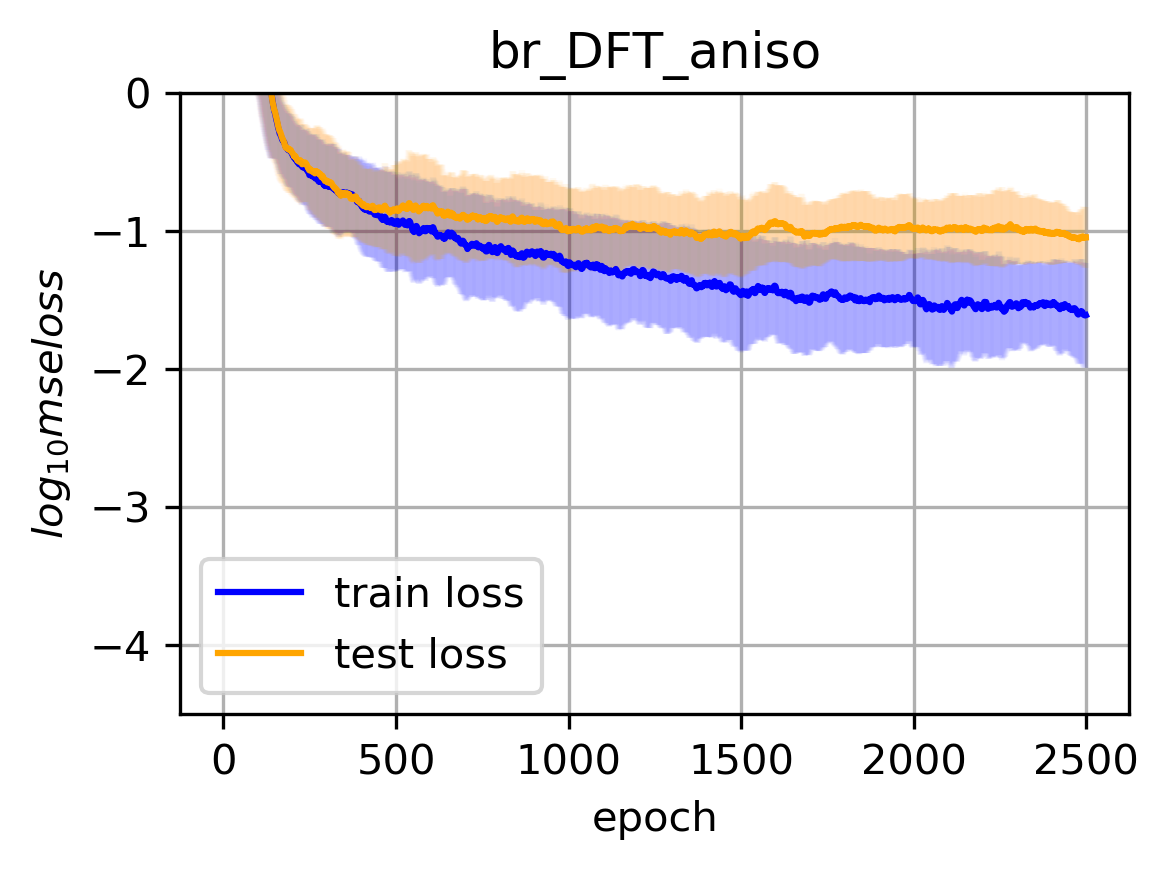

In [3]:
file_path = 'args.txt'  # Replace with the path to text file
ele, model_struc, epochs = load_config_values(file_path)
print(ele)

label_type = 'eda_aniso'

save_path = label_type +'/'

filepath_sobol = '/global/home/users/yifancui/delta-ml/dataset_v1.0/xyz/h2o_'+ele+'_sobol.xyz'
filepath_aimd = '/global/home/users/yifancui/delta-ml/dataset_v1.0/xyz/h2o_'+ele+'_aimd.xyz'
xyz_sobol = load_xyz(filepath_sobol)
xyz_aimd = load_xyz(filepath_aimd)
xyz = np.concatenate((xyz_sobol,xyz_aimd),axis=0)


##   SOBOL + AIMD

label = ['cls_elec','ct','mod_pauli','pol','disp']

E_eda_sobol = pd.read_csv('/global/home/users/yifancui/delta-ml/dataset_v1.0/eda_labels/h2o_'+ele+'_sobol.csv')[label]
E_eda_aimd = pd.read_csv('/global/home/users/yifancui/delta-ml/dataset_v1.0/eda_labels/h2o_'+ele+'_aimd.csv')[label]

if label_type == 'eda_aniso':
    E_aniso_sobol = pd.read_csv('/global/home/users/yifancui/delta-ml/dataset_v1.0/ff_aniso_labels/h2o_'+ele+'_sobol_ff_aniso.csv')[label]
    E_aniso_aimd = pd.read_csv('/global/home/users/yifancui/delta-ml/dataset_v1.0/ff_aniso_labels/h2o_'+ele+'_aimd_ff_aniso.csv')[label]
    E = np.concatenate((E_eda_sobol-E_aniso_sobol,E_eda_aimd-E_aniso_aimd),axis=0)
    label_type = 'DFT_aniso'

if label_type  == 'eda_dipole':
    E_dipole_sobol = pd.read_csv('/global/home/users/yifancui/delta-ml/dataset_v1.0/ff_dipole_labels/h2o_'+ele+'_sobol_ff_dipole.csv')[label]
    E_dipole_aimd = pd.read_csv('/global/home/users/yifancui/delta-ml/dataset_v1.0/ff_dipole_labels/h2o_'+ele+'_aimd_ff_dipole.csv')[label]
    E = np.concatenate((E_eda_sobol-E_dipole_sobol,E_eda_aimd-E_dipole_aimd),axis=0)
    label_type = 'DFT_dipole'
    
if label_type  == 'eda':
    E = np.concatenate((E_eda_sobol,E_eda_aimd),axis=0)
    
    
# select 10,000 data points not included in the training set
size = len(xyz)
indices = list(range(size))
random.shuffle(indices)
train_indices = np.loadtxt(save_path+ 'train_indices.txt').tolist()
test_indices = list(set(indices)-set(train_indices))
random.shuffle(test_indices)
test_indices = test_indices[:10000]

xyz_test, E_test = xyz[test_indices], E[test_indices]
dist_all = np.array([dist(x) for x in xyz_test],dtype=np.float16)
dist_ion_water = dist_all[:,0,3]

hyb_test = hyb_n(xyz_test)
x_test = torch.tensor(hyb_test)
x_test = x_test.view(10000,16)
x_test = x_test.to(torch.float32)




device = torch.device('cpu')
model = torch.load(save_path+"best_model.pt",map_location=torch.device('cpu'))
model.to(device)
model.eval()
x_test = x_test.to(device)
output = model(x_test)
output_numpy = output.detach().numpy()

for i in range(5):
    plt.figure(figsize = (4,3),dpi=300)
    plt.scatter(dist_ion_water,output_numpy[:,i],s=0.3,alpha=0.7,label=r'$E_{delta-ml}$')
    plt.scatter(dist_ion_water,E_test[:,i],s=0.3,alpha=0.3,label=r'$E_{eda}-E_{ff(aniso)}$')
    plt.xlabel(r'$r(\AA)$')
    plt.ylabel('E(kJ/mol)')
    plt.legend(loc='best',markerscale=6)
    
    if i ==0:
        plt.title(label_type+'_cls_elec_'+ele)
        plt.tight_layout()
        plt.savefig(save_path+ele+'_'+label_type+'_cls_elec_r.jpg')
    if i ==1:
        plt.title(label_type+'_ct_'+ele)
        plt.tight_layout()
        plt.savefig(save_path+ele+'_'+label_type+'_ct_r.jpg')
    if i ==2:
        plt.title(label_type+'_mod_pauli_'+ele)
        plt.tight_layout()
        plt.savefig(save_path+ele+'_'+label_type+'_mod_pauli_r.jpg')
    if i ==3:
        plt.title(label_type+'_pol_'+ele)
        plt.tight_layout()
        plt.savefig(save_path+ele+'_'+label_type+'_pol_r.jpg')
    if i ==4:
        plt.title(label_type+'_disp_'+ele)
        plt.tight_layout()
        plt.savefig(save_path+ele+'_'+label_type+'_disp_r.jpg')
        
        
plot_scatter(E_test[:,0],output_numpy[:,0],save_path,ele+'_'+label_type+'_cls_elec')
plot_scatter(E_test[:,1],output_numpy[:,1],save_path,ele+'_'+label_type+'_ct')
plot_scatter(E_test[:,2],output_numpy[:,2],save_path,ele+'_'+label_type+'_mod_pauli')
plot_scatter(E_test[:,3],output_numpy[:,3],save_path,ele+'_'+label_type+'_pol')
plot_scatter(E_test[:,4],output_numpy[:,4],save_path,ele+'_'+label_type+'_disp')
plot_box((E_test-output_numpy),save_path,ele,label_type)

E_test_eda_aniso = E_test
E_dml_eda_aniso = output_numpy


train_loss = np.loadtxt(save_path+'Train_mseloss_1.txt')
test_loss = np.loadtxt(save_path+'Test_mseloss_1.txt')
fig, axs = plt.subplots(1, 1,figsize=(4,3),dpi=300)

plot_mean_with_errorbars( np.arange(len(train_loss)),np.log10(train_loss), 100, 50,'blue',axs,label = 'train loss')
plot_mean_with_errorbars( np.arange(len(test_loss)),np.log10(test_loss), 100, 50,'orange',axs,label = 'test loss')

axs.set_xlabel('epoch')
axs.set_ylabel(r'$log_{10}mseloss$')
axs.set_title(ele+'_'+label_type)
axs.set_ylim(-4.5,0)
plt.tight_layout()
fig.savefig(save_path+ele+'_'+label_type+'_train_test.jpg')


In [4]:
'''
H1 = xyz[:,1,1:]
H2 = xyz[:,2,1:]
O = xyz[:,0,1:]
X = xyz[:,3,1:]
r = H1 + H2 - 2*O
d = O - X

dis = (np.sum(d**2,axis=1)**0.5).astype(np.float64)

theta = np.sum(r * d, axis=1)/(np.sum(r**2,axis=1)**0.5 * dis)


for i in range(5):
    plt.figure(figsize = (4,3),dpi=600)
    plt.scatter(np.log10(dis), theta, c=E[:,i], cmap='viridis', marker='o', s=0.1, alpha=0.5)
    plt.colorbar()
    
    
    if i ==0:
        plt.title(label_type+'_cls_elec_'+ele)
        plt.savefig(save_path+ele+'_cls_elec_data.jpg')
    if i ==1:
        plt.title(label_type+'_ct_'+ele)
        plt.savefig(save_path+ele+'_ct_data.jpg')
    if i ==2:
        plt.title(label_type+'_mod_pauli_'+ele)
        plt.savefig(save_path+ele+'_mod_pauli_data.jpg')
    if i ==3:
        plt.title(label_type+'_pol_'+ele)
        plt.savefig(save_path+ele+'_pol_data.jpg')
    if i ==4:
        plt.title(label_type+'_disp_'+ele)
        plt.savefig(save_path+ele+'_disp_data.jpg')

'''


"\nH1 = xyz[:,1,1:]\nH2 = xyz[:,2,1:]\nO = xyz[:,0,1:]\nX = xyz[:,3,1:]\nr = H1 + H2 - 2*O\nd = O - X\n\ndis = (np.sum(d**2,axis=1)**0.5).astype(np.float64)\n\ntheta = np.sum(r * d, axis=1)/(np.sum(r**2,axis=1)**0.5 * dis)\n\n\nfor i in range(5):\n    plt.figure(figsize = (4,3),dpi=600)\n    plt.scatter(np.log10(dis), theta, c=E[:,i], cmap='viridis', marker='o', s=0.1, alpha=0.5)\n    plt.colorbar()\n    \n    \n    if i ==0:\n        plt.title(label_type+'_cls_elec_'+ele)\n        plt.savefig(save_path+ele+'_cls_elec_data.jpg')\n    if i ==1:\n        plt.title(label_type+'_ct_'+ele)\n        plt.savefig(save_path+ele+'_ct_data.jpg')\n    if i ==2:\n        plt.title(label_type+'_mod_pauli_'+ele)\n        plt.savefig(save_path+ele+'_mod_pauli_data.jpg')\n    if i ==3:\n        plt.title(label_type+'_pol_'+ele)\n        plt.savefig(save_path+ele+'_pol_data.jpg')\n    if i ==4:\n        plt.title(label_type+'_disp_'+ele)\n        plt.savefig(save_path+ele+'_disp_data.jpg')\n\n"

# eda-dipole

br


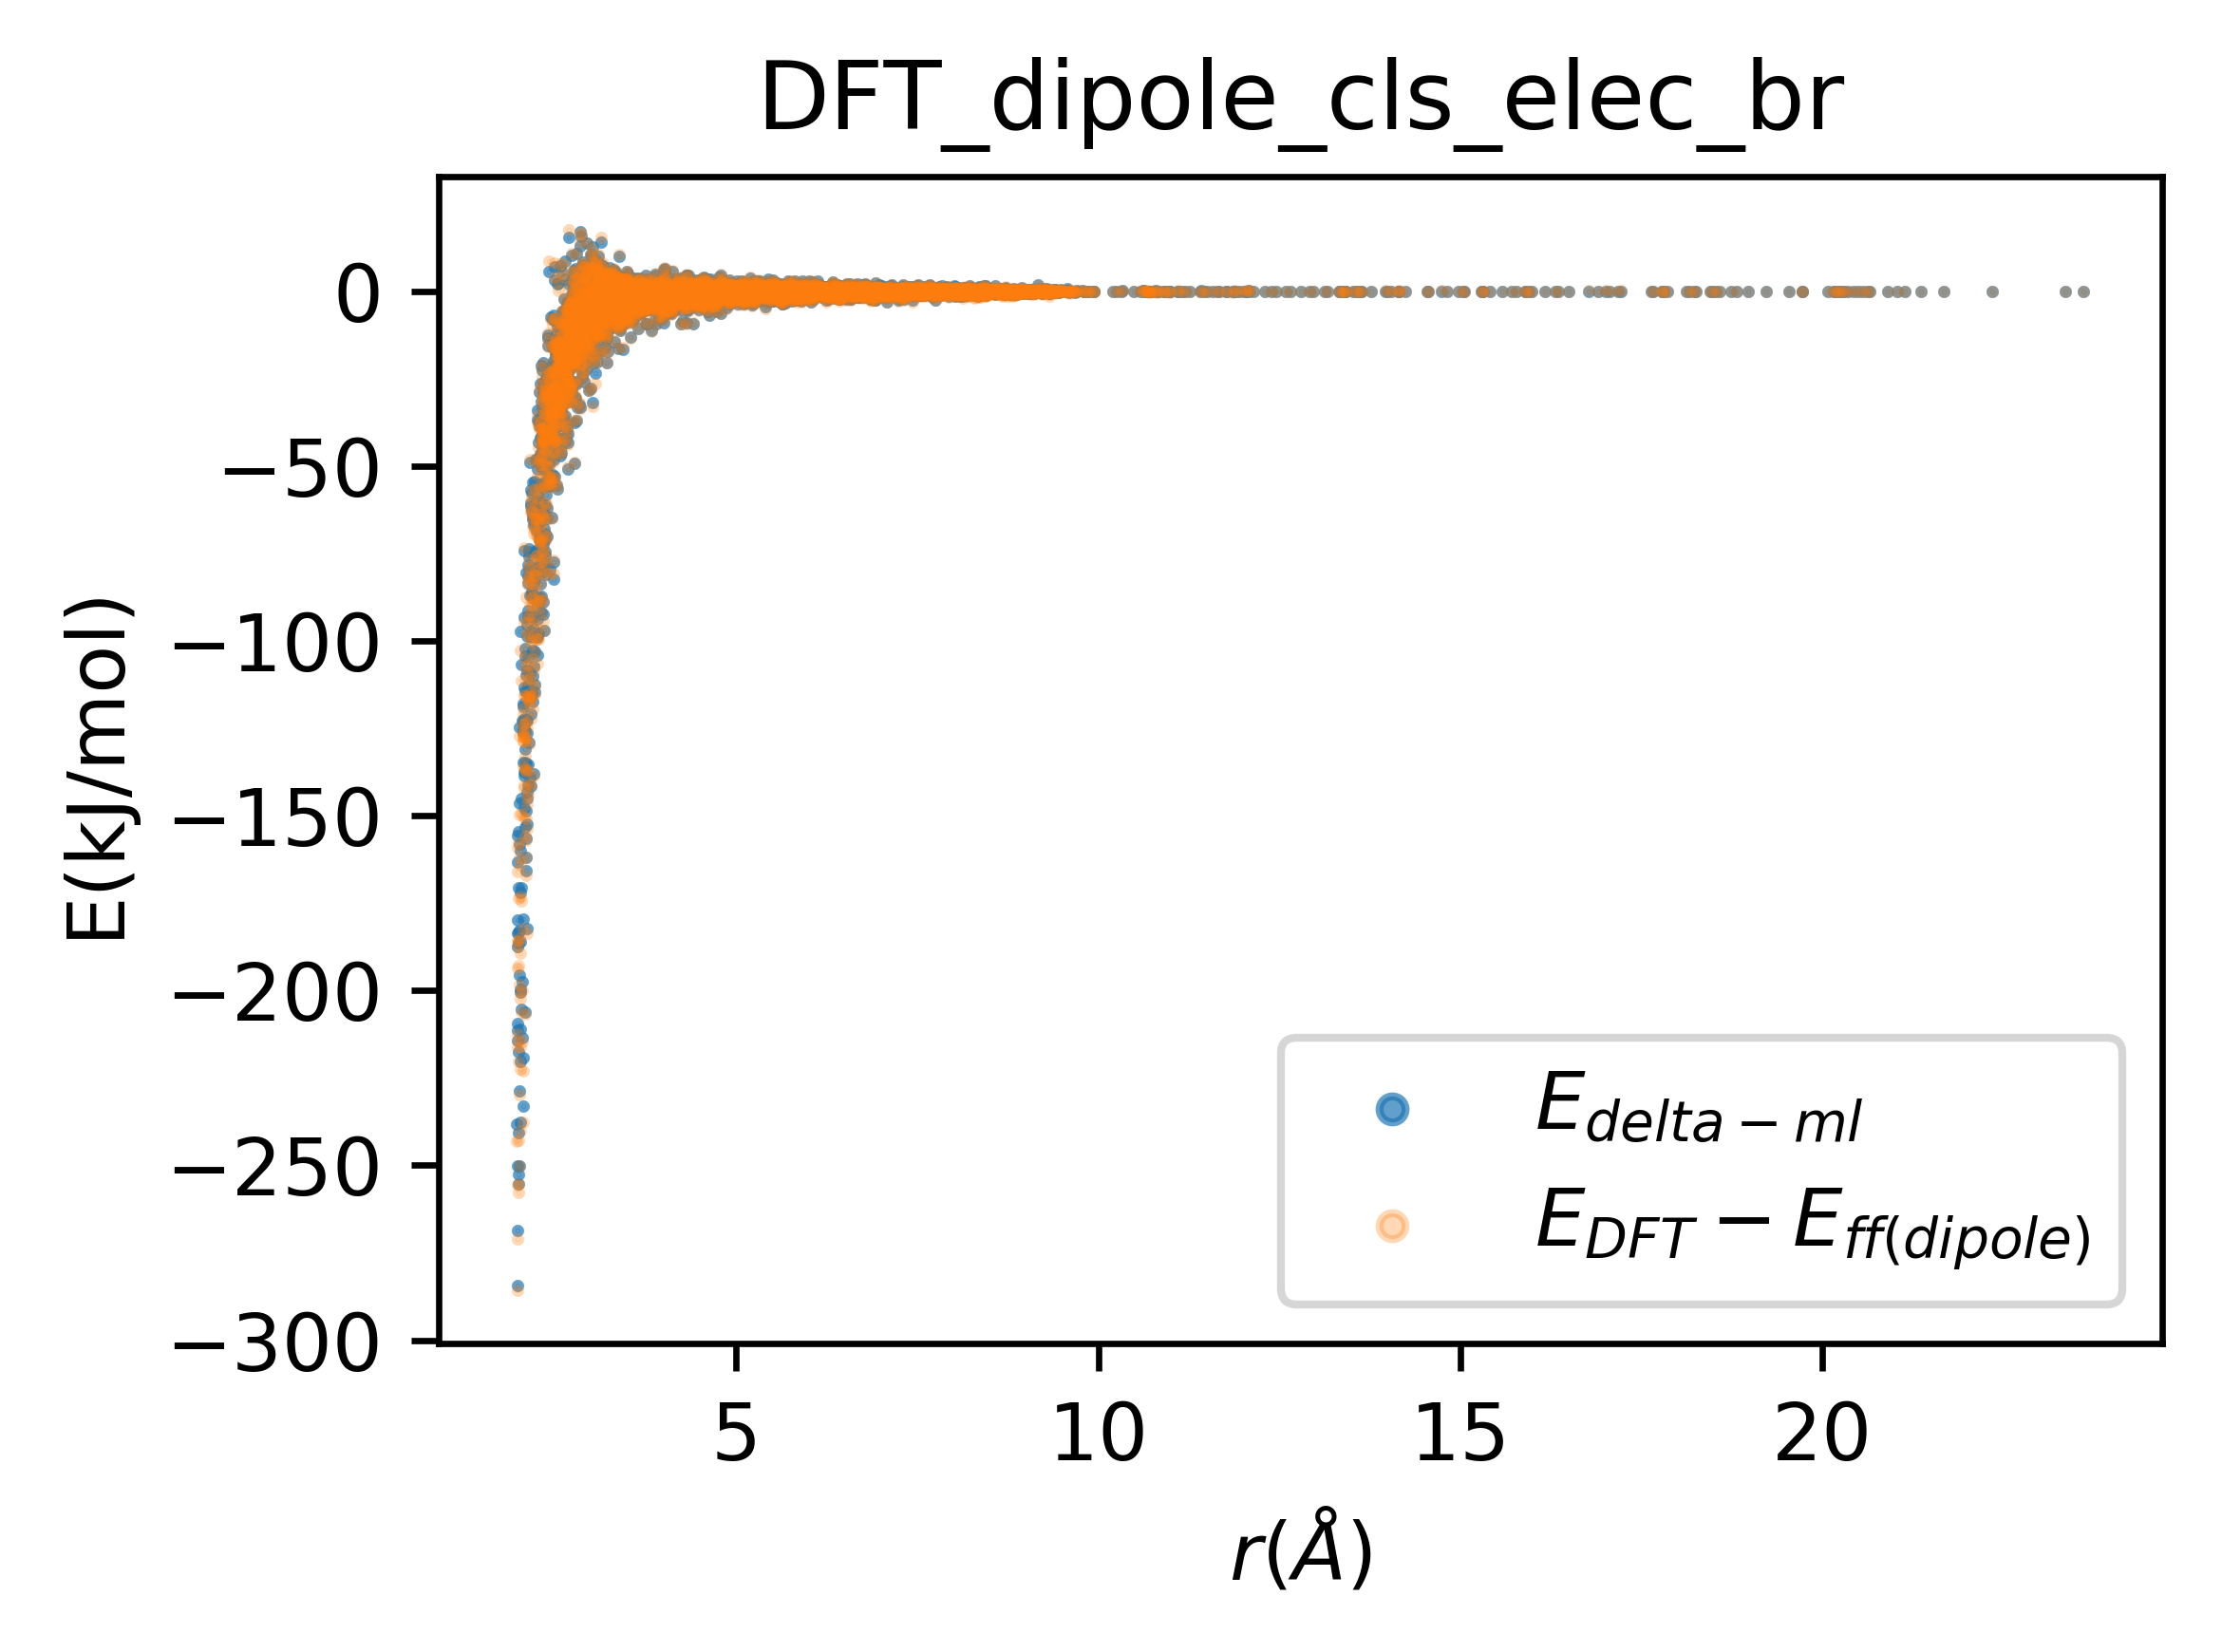

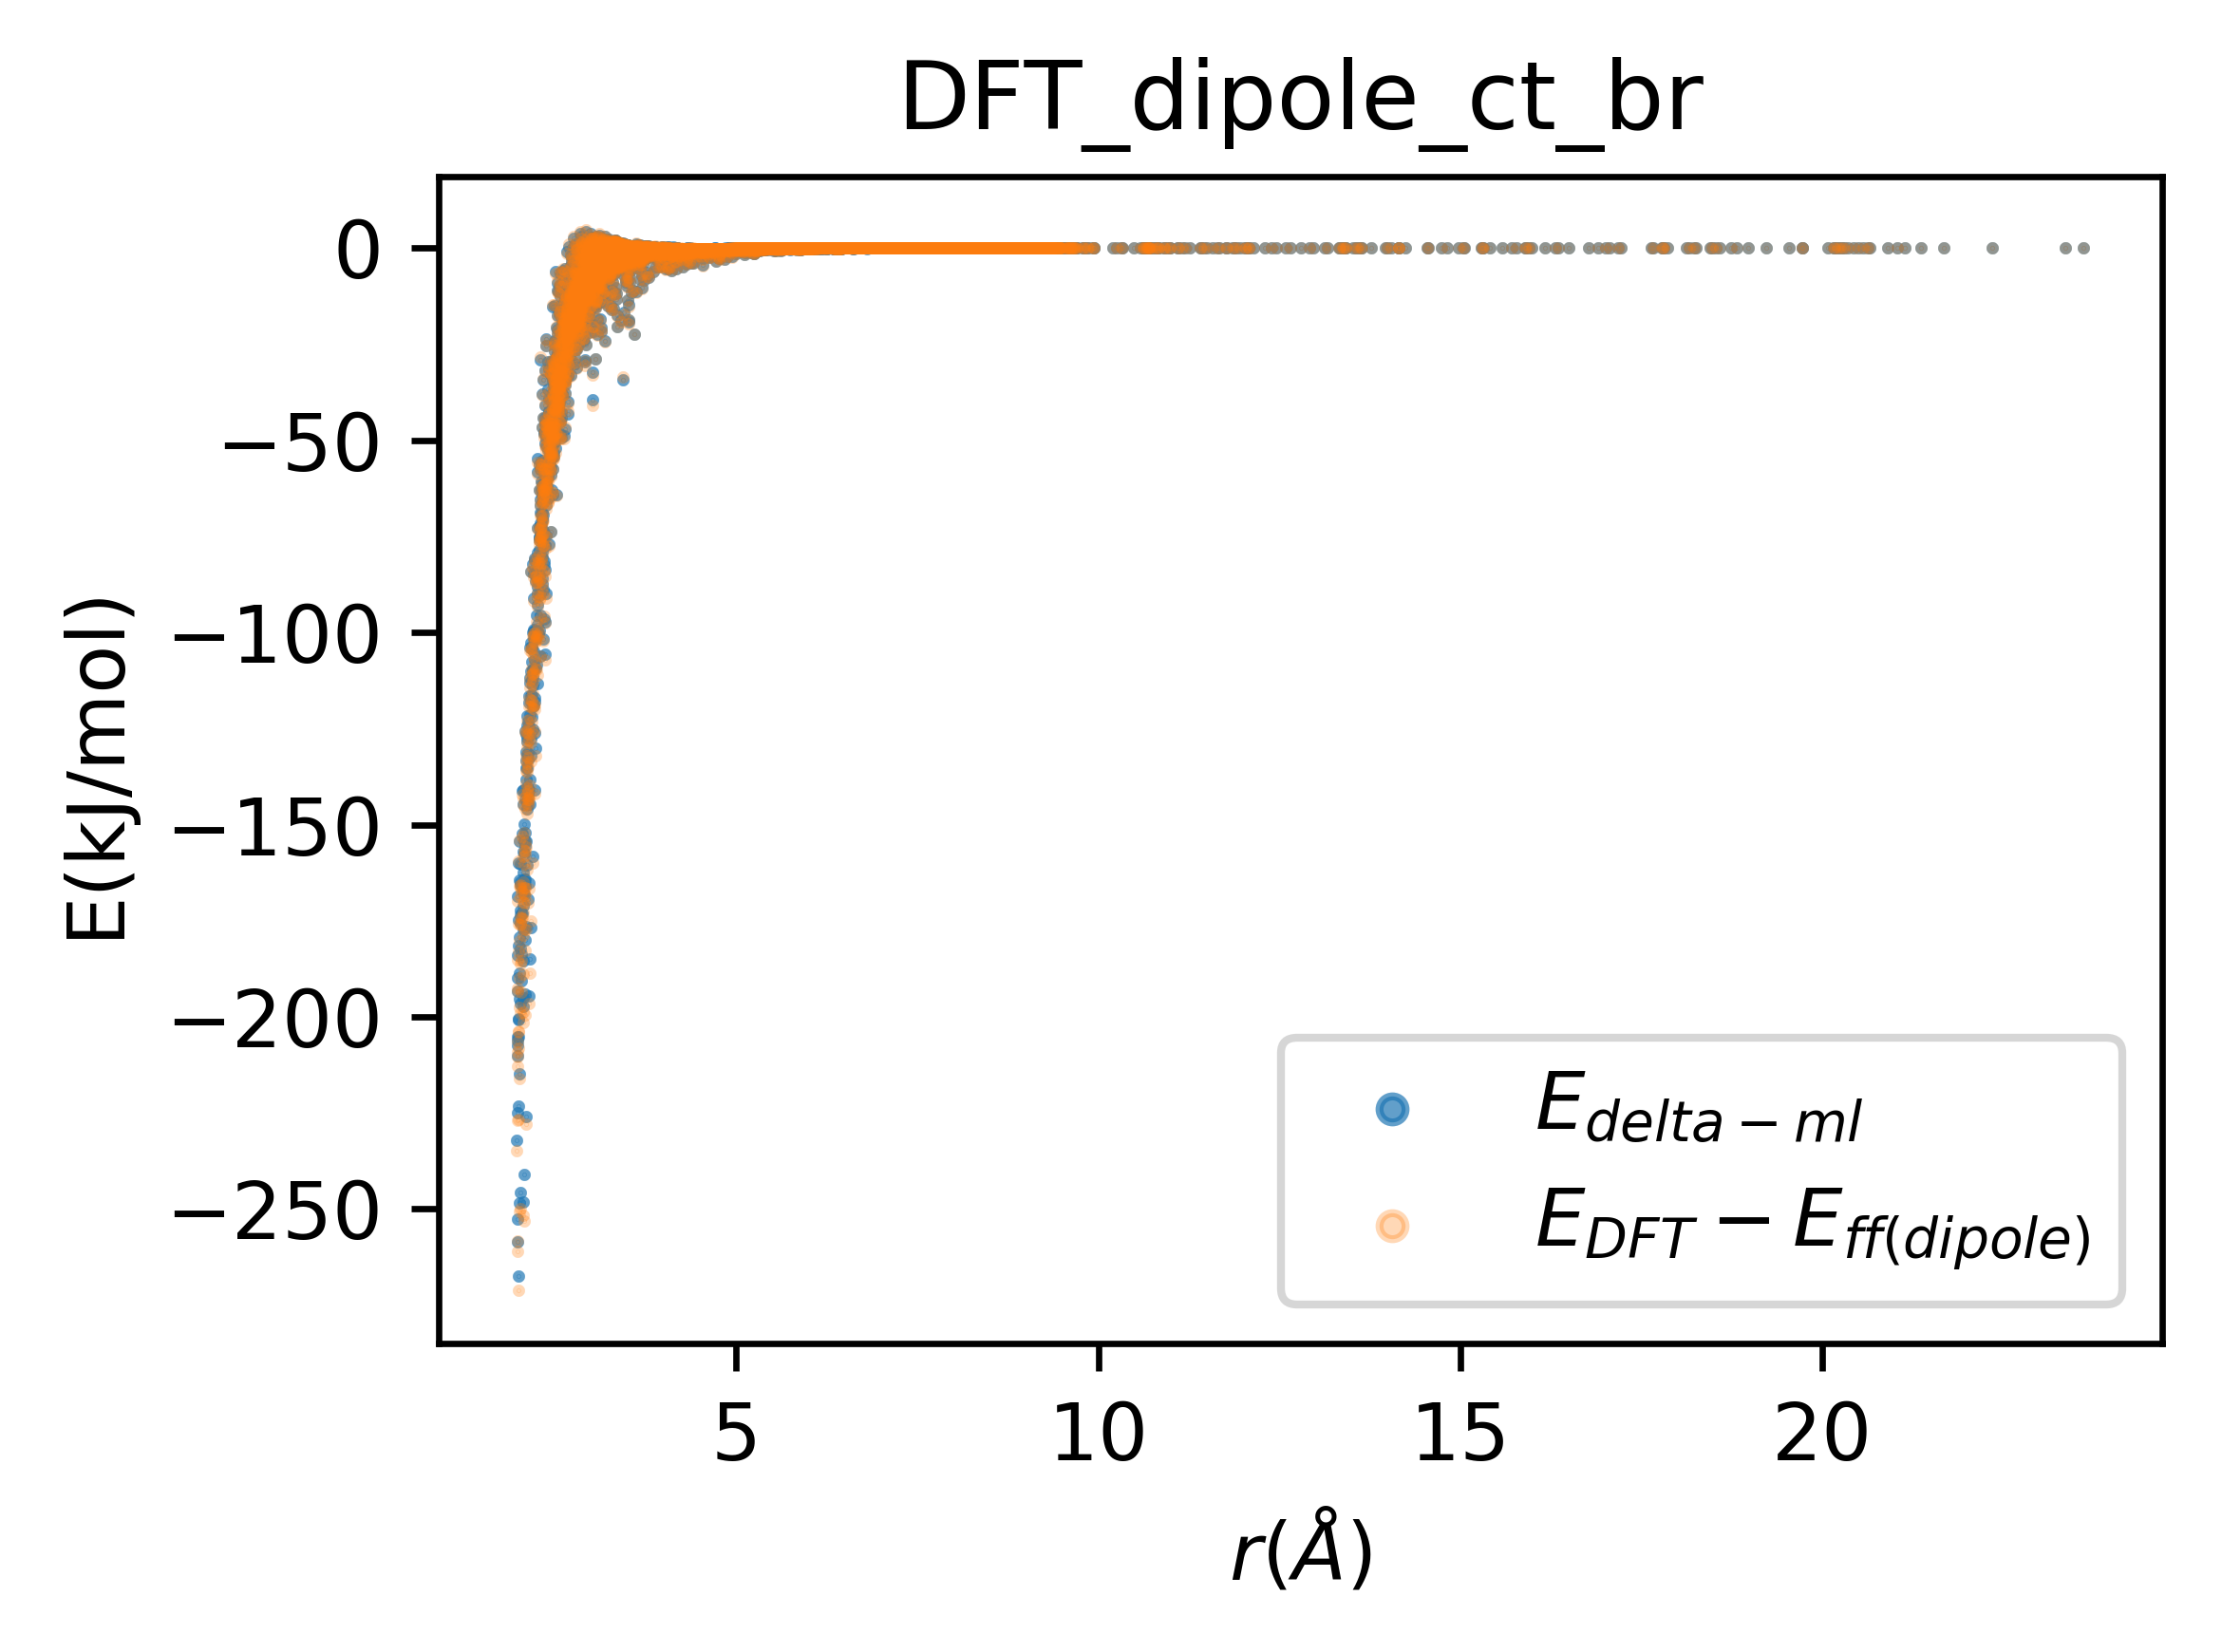

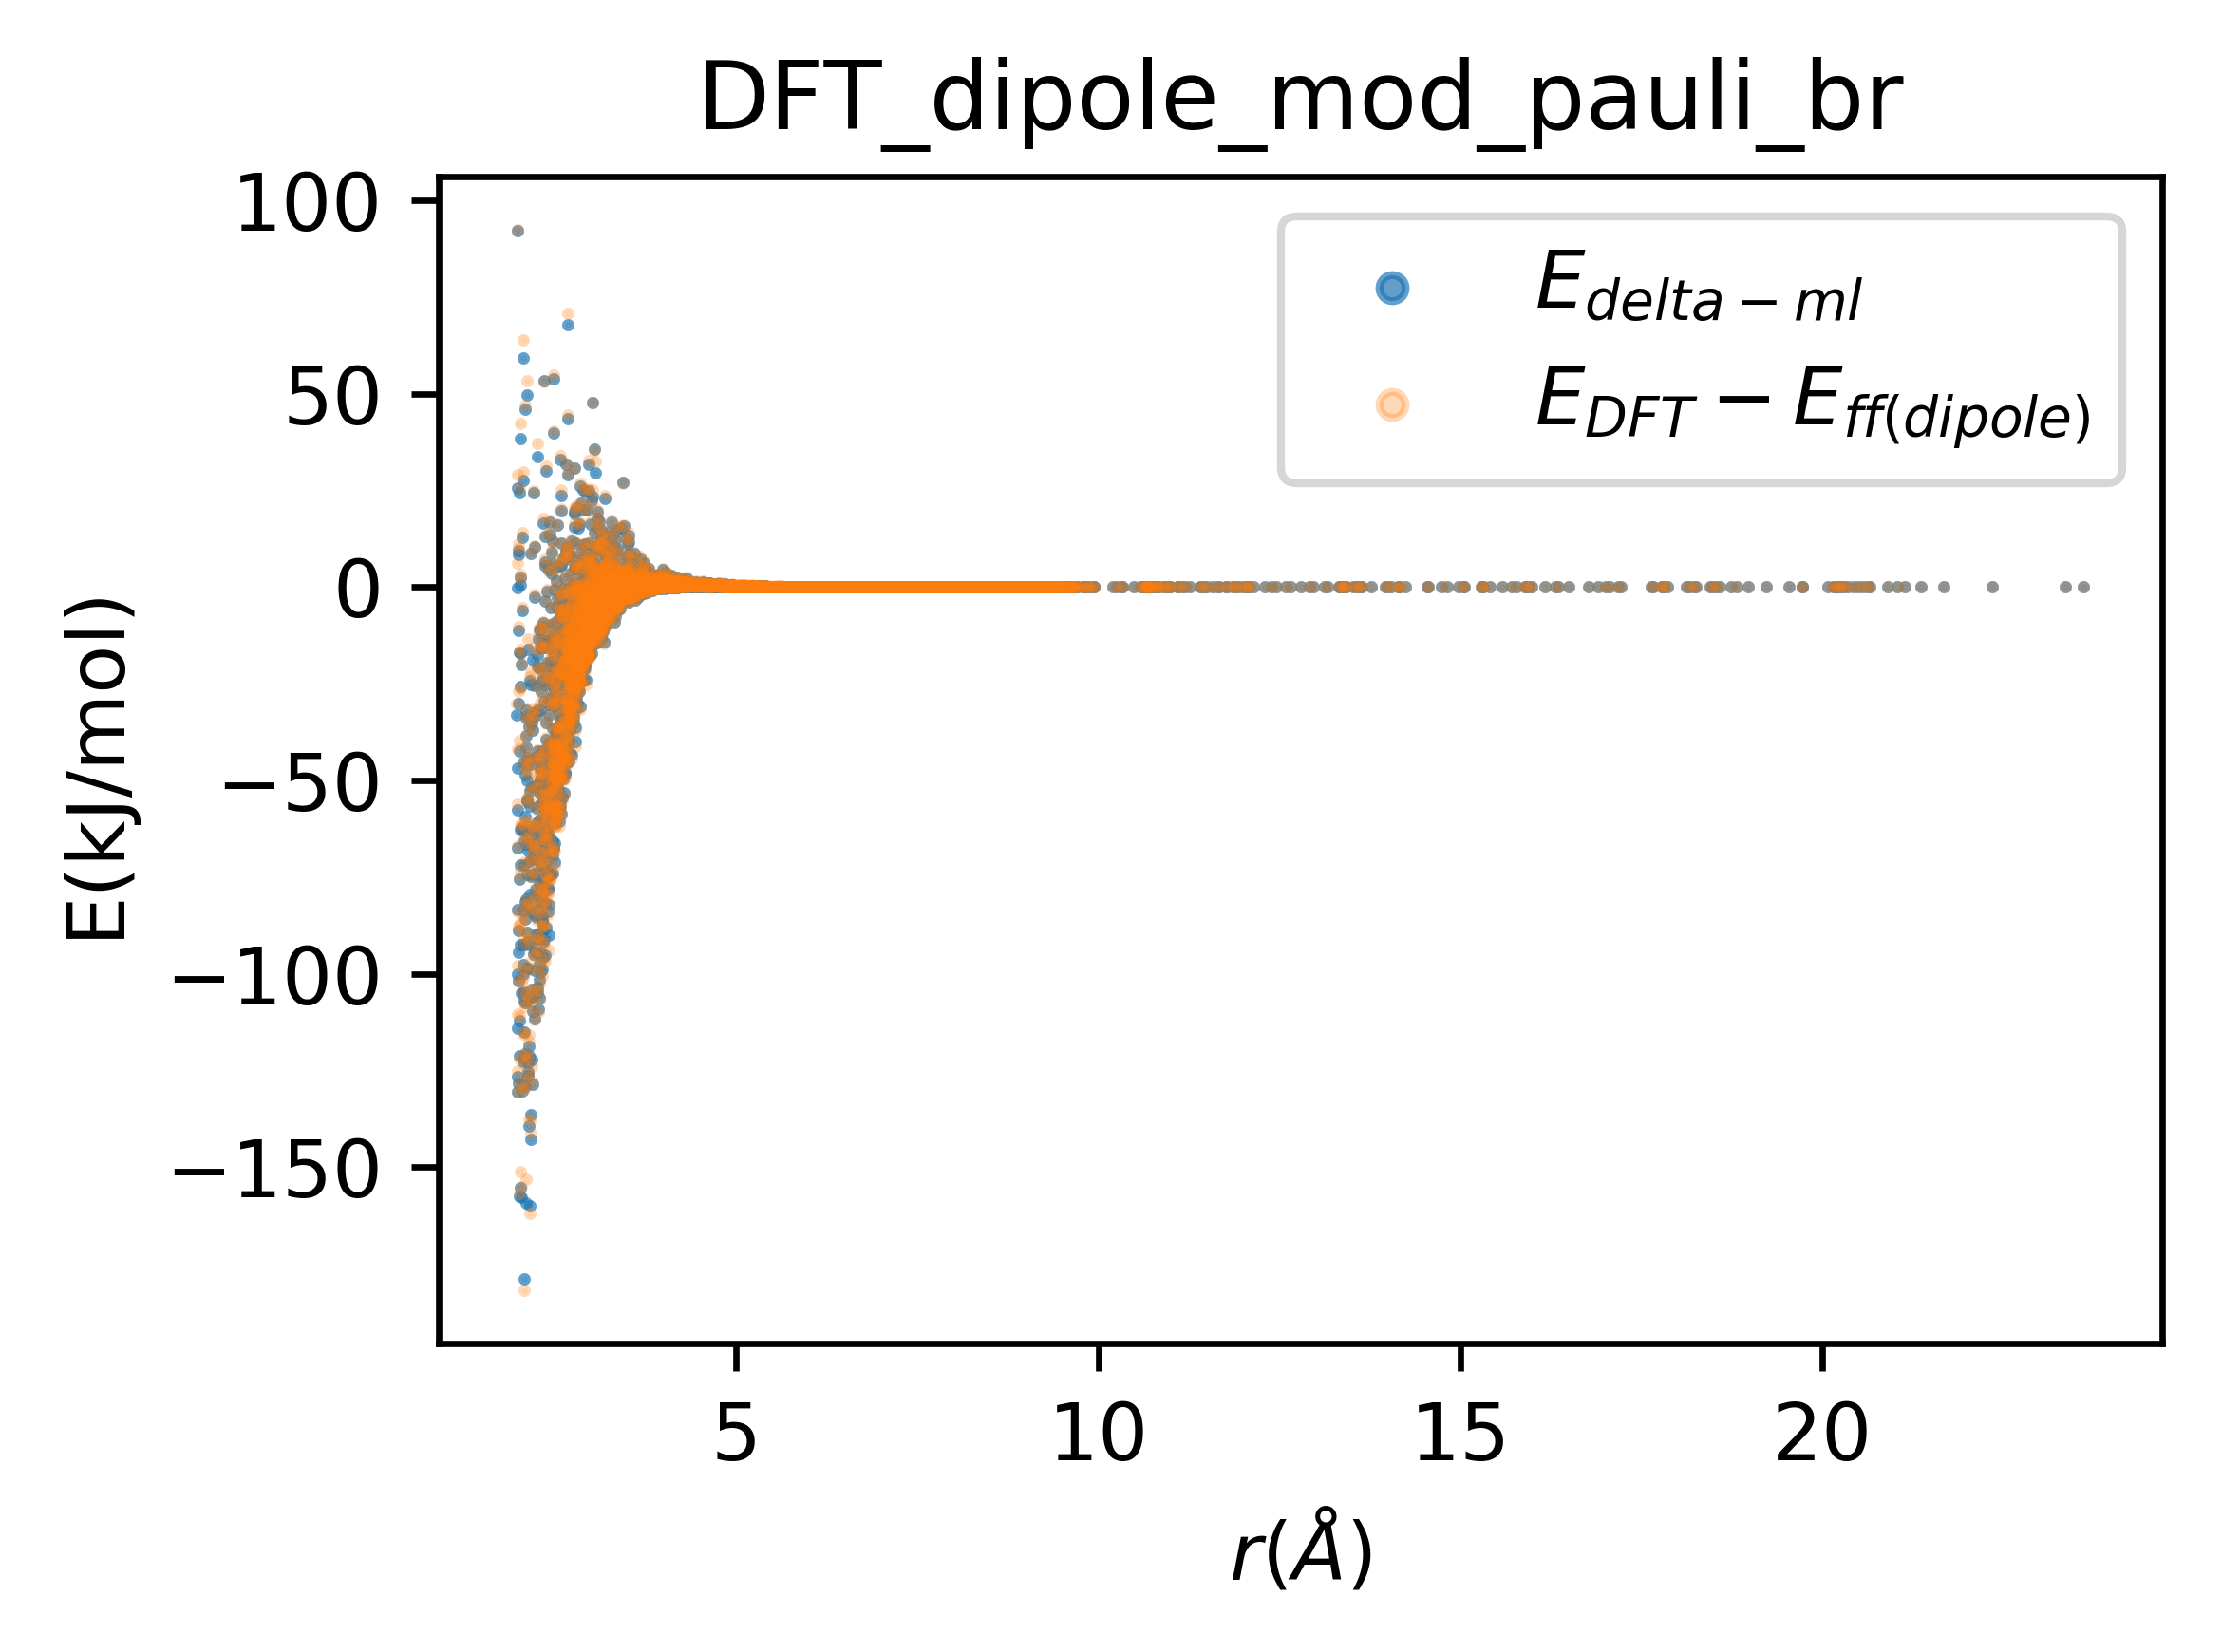

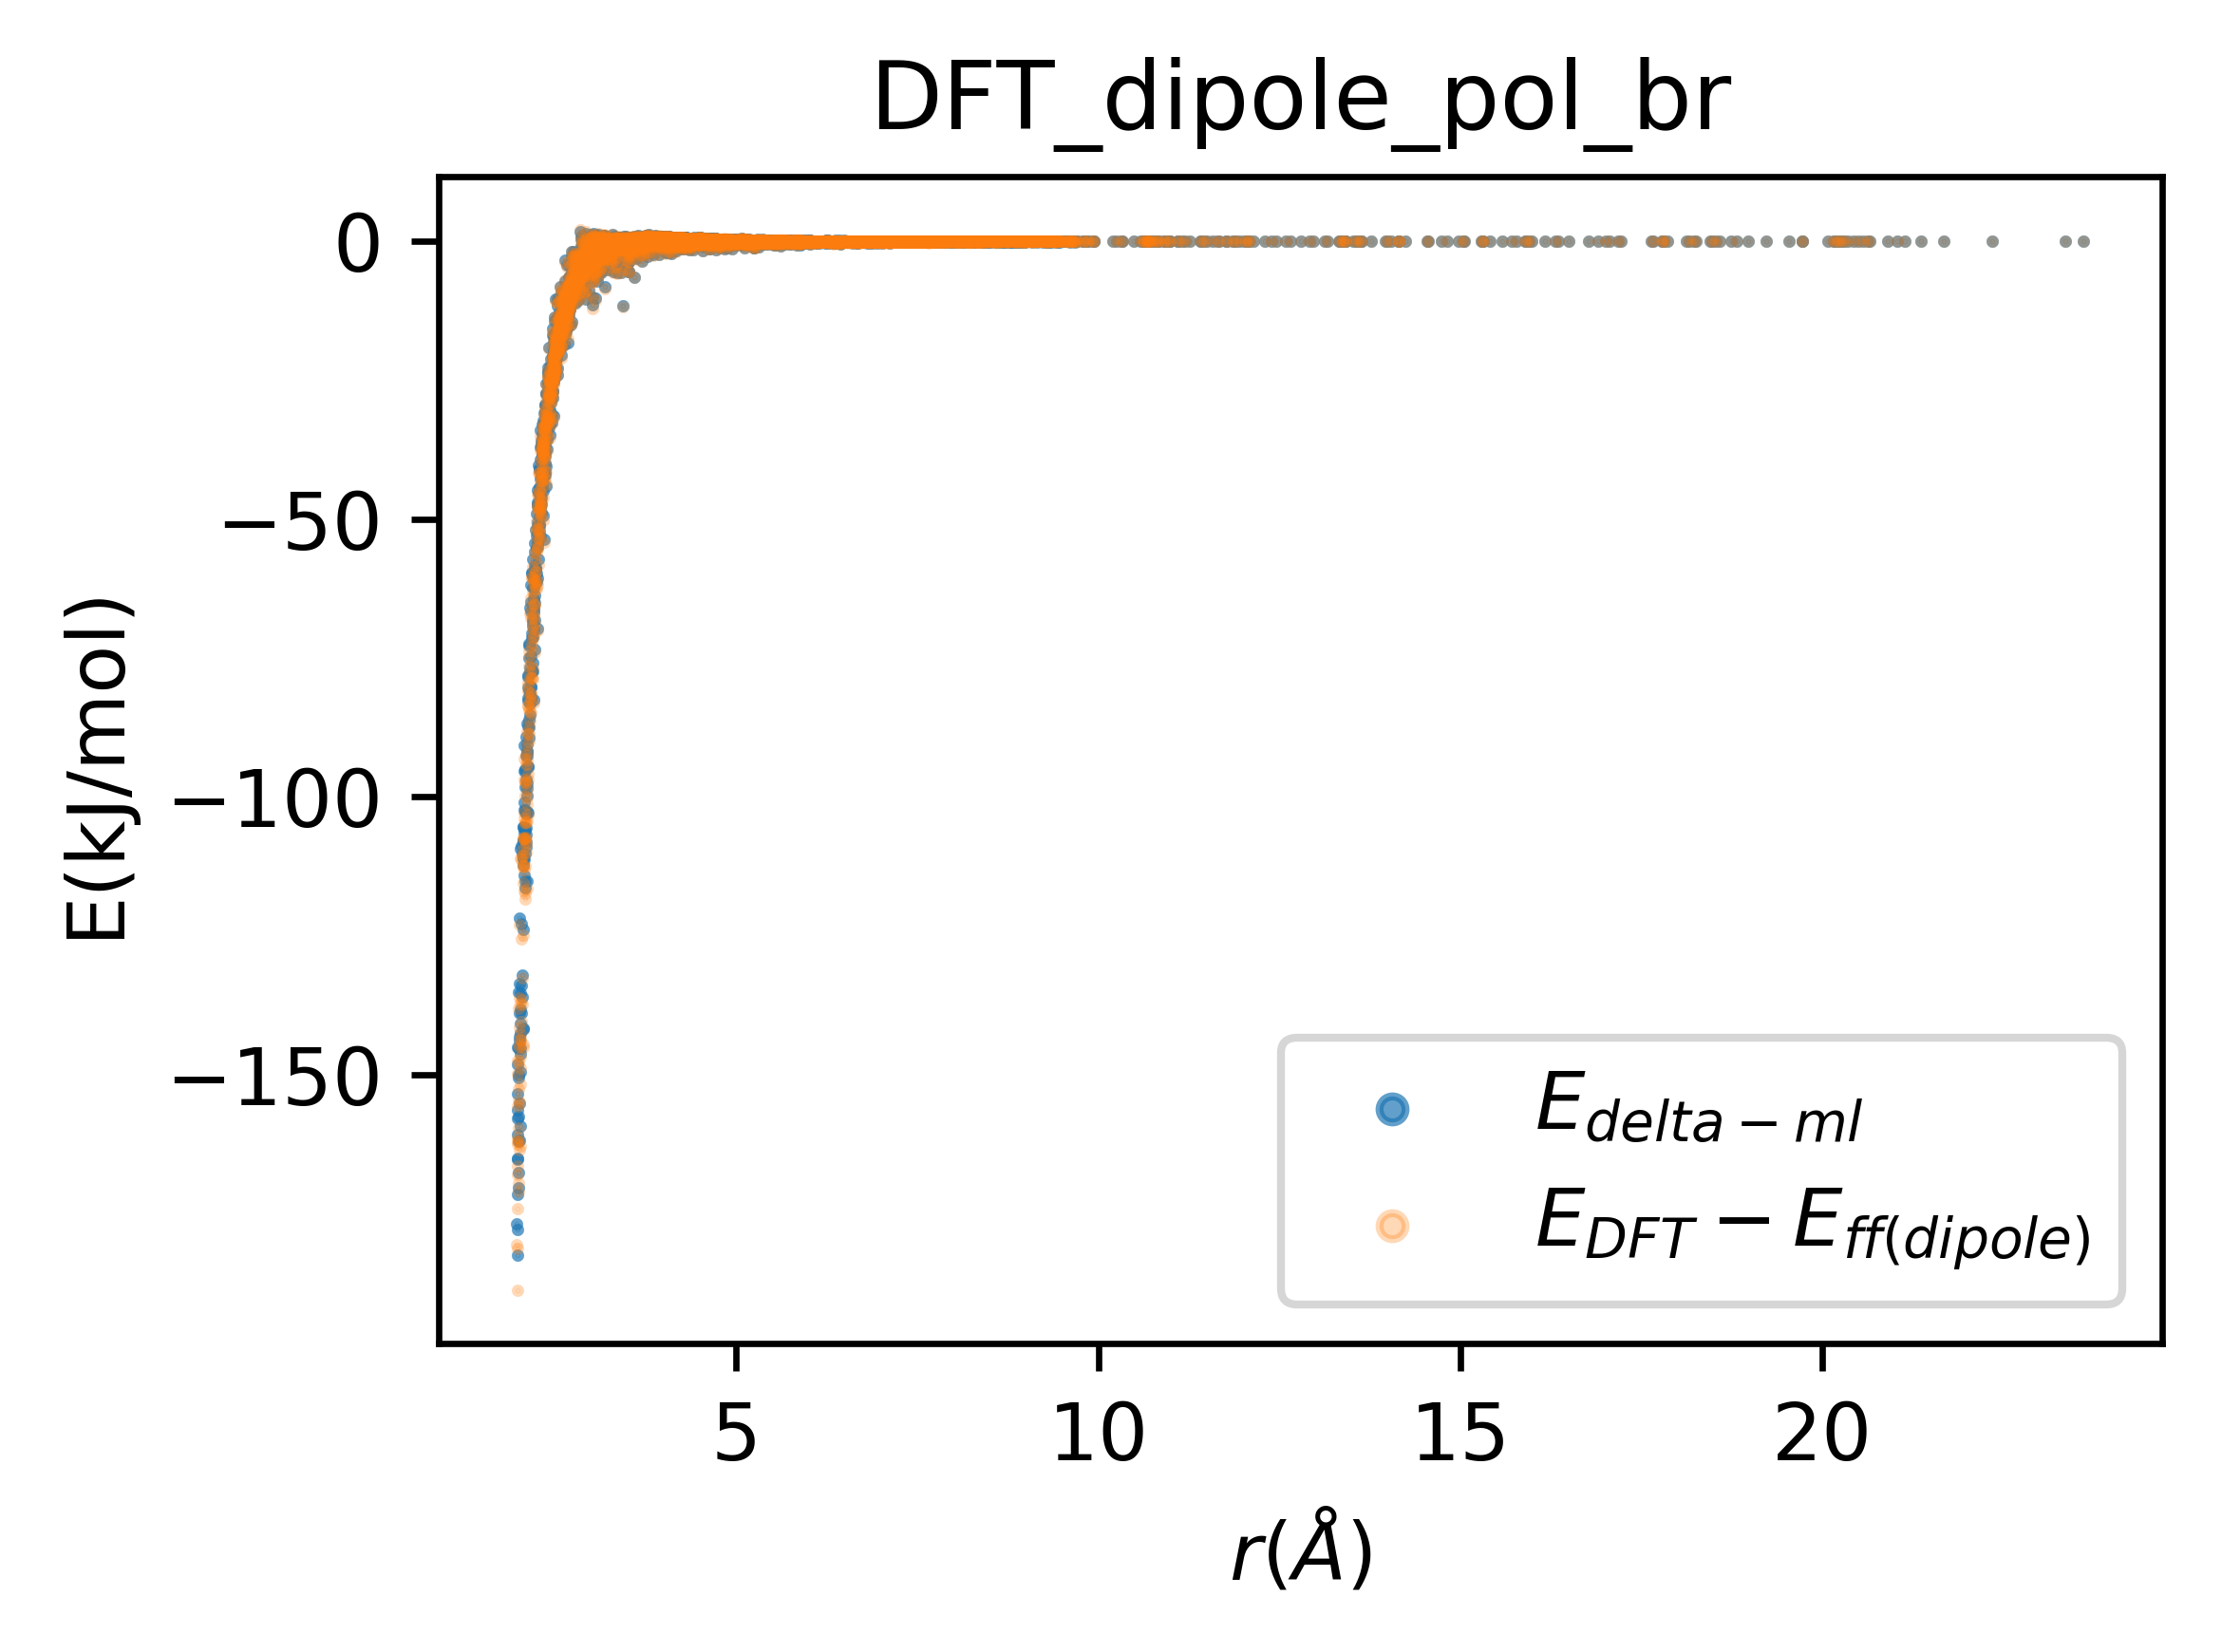

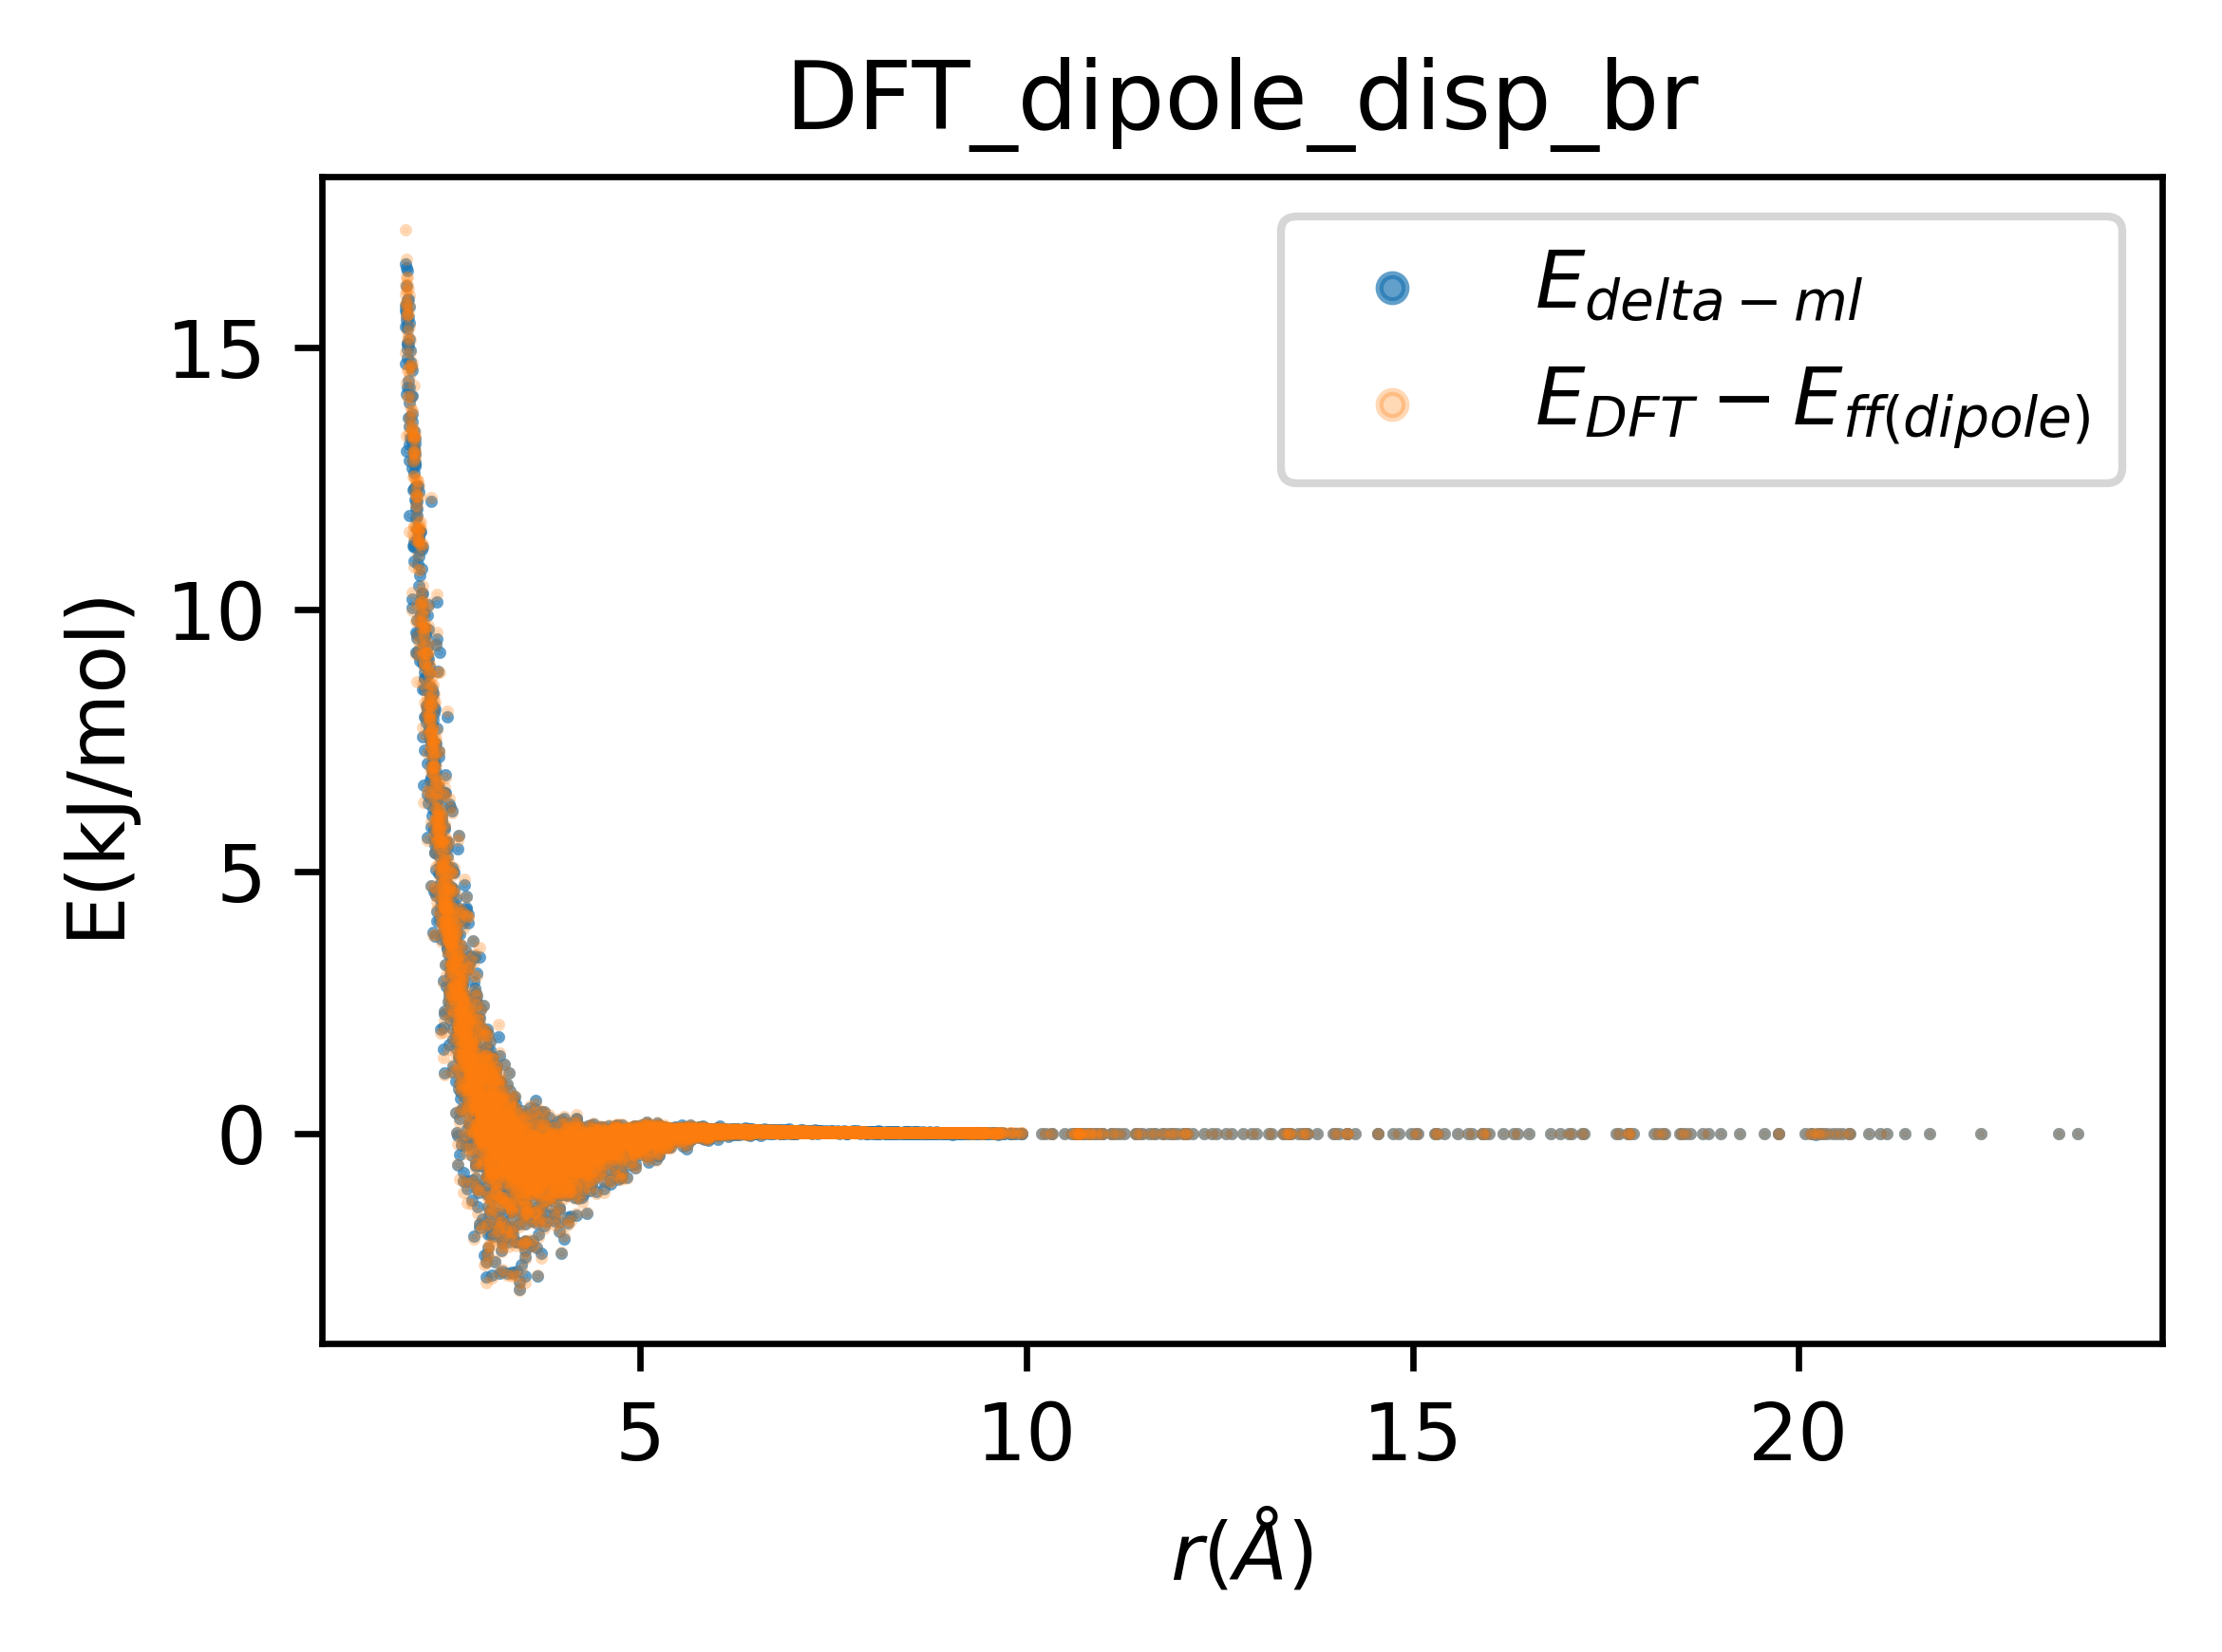

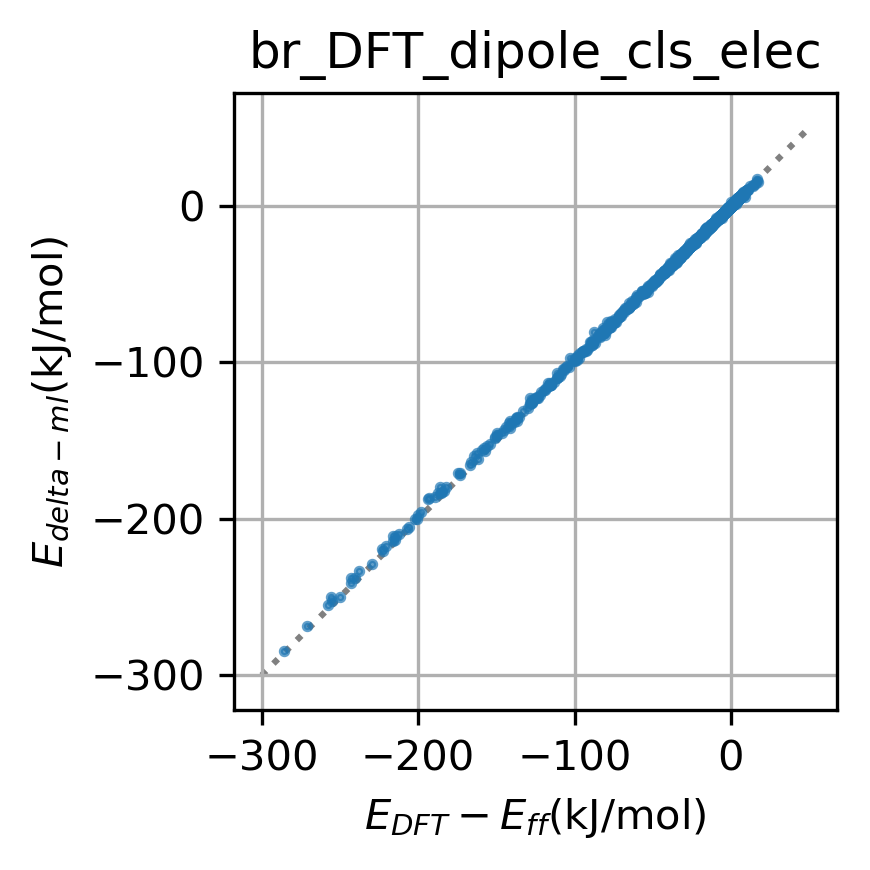

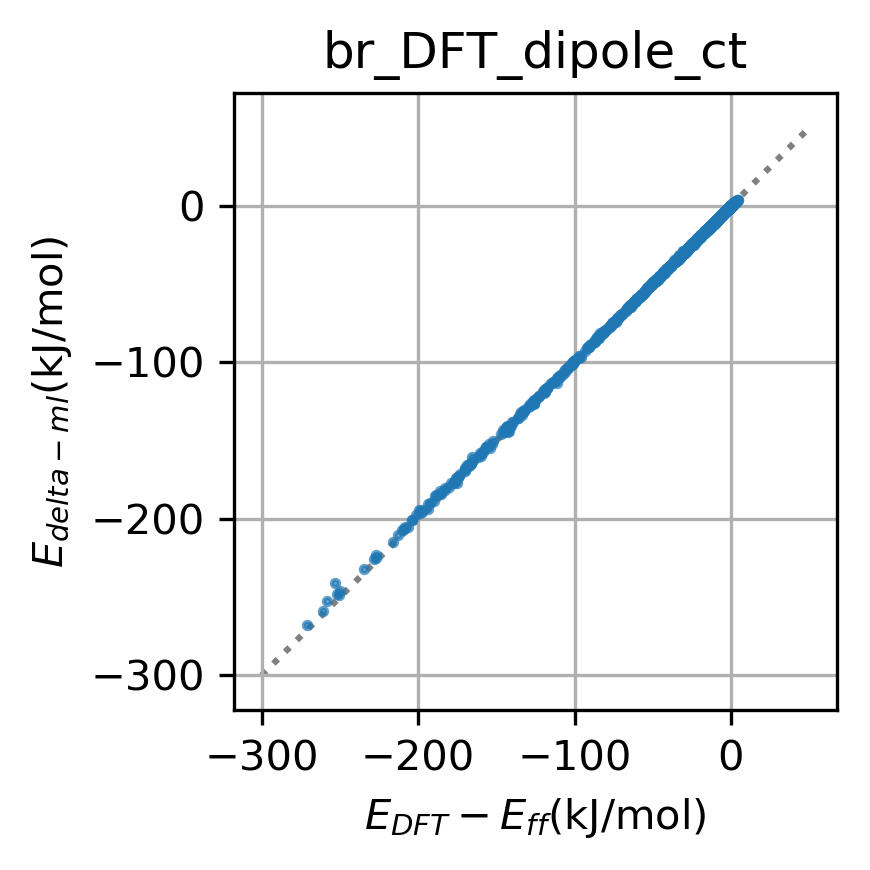

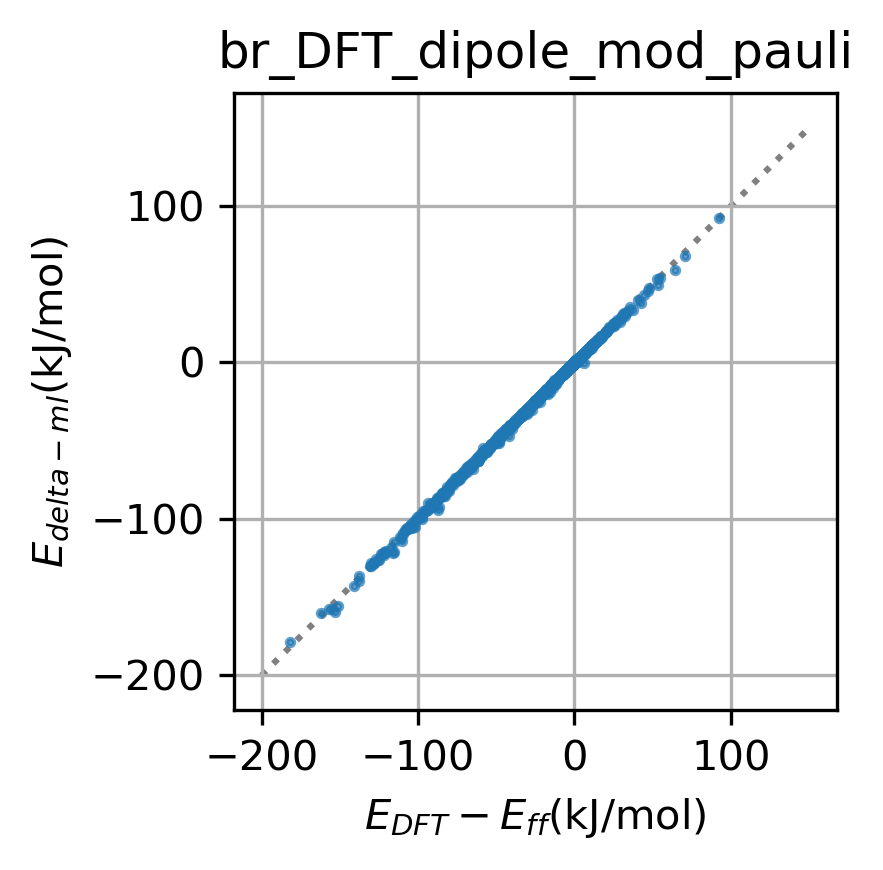

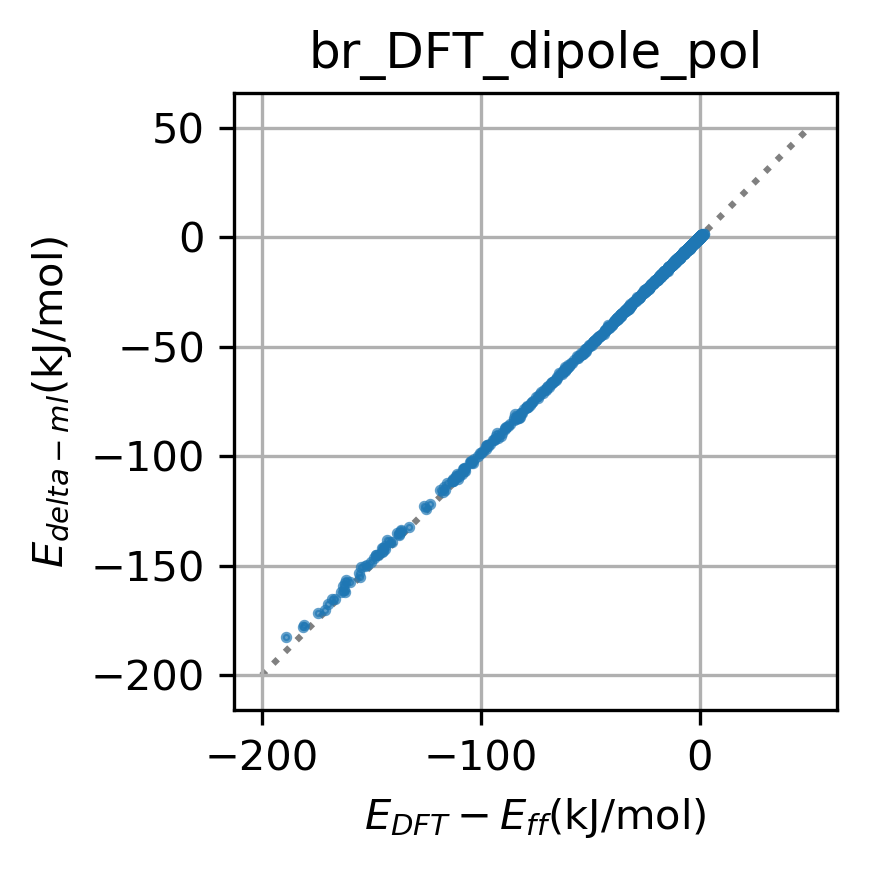

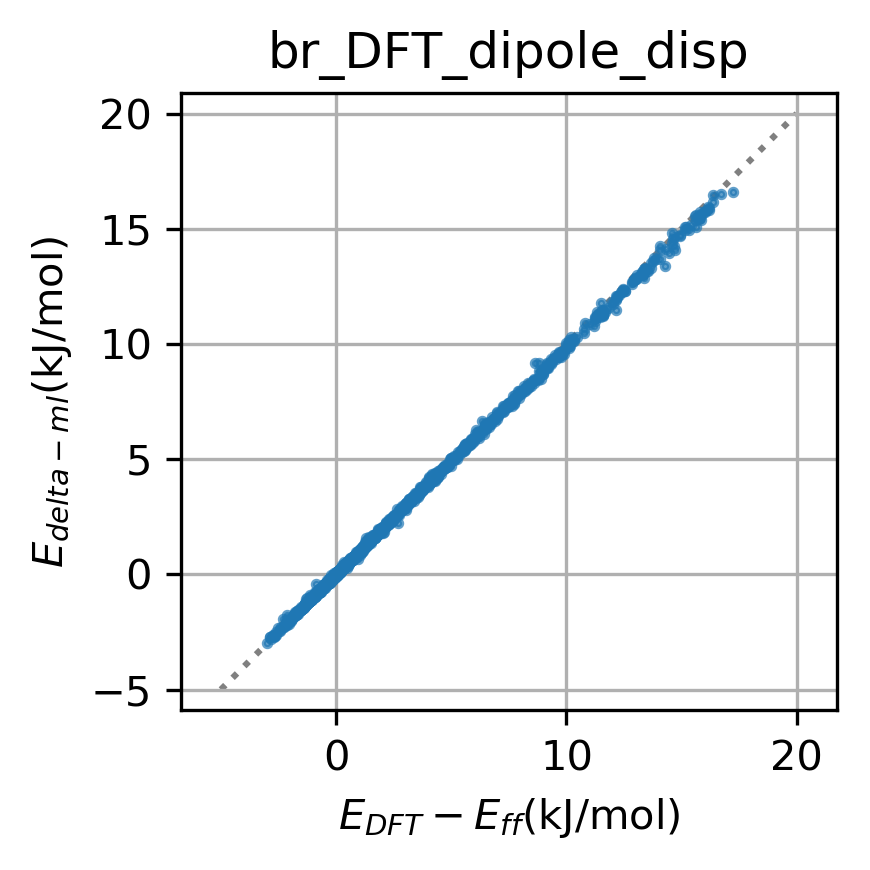

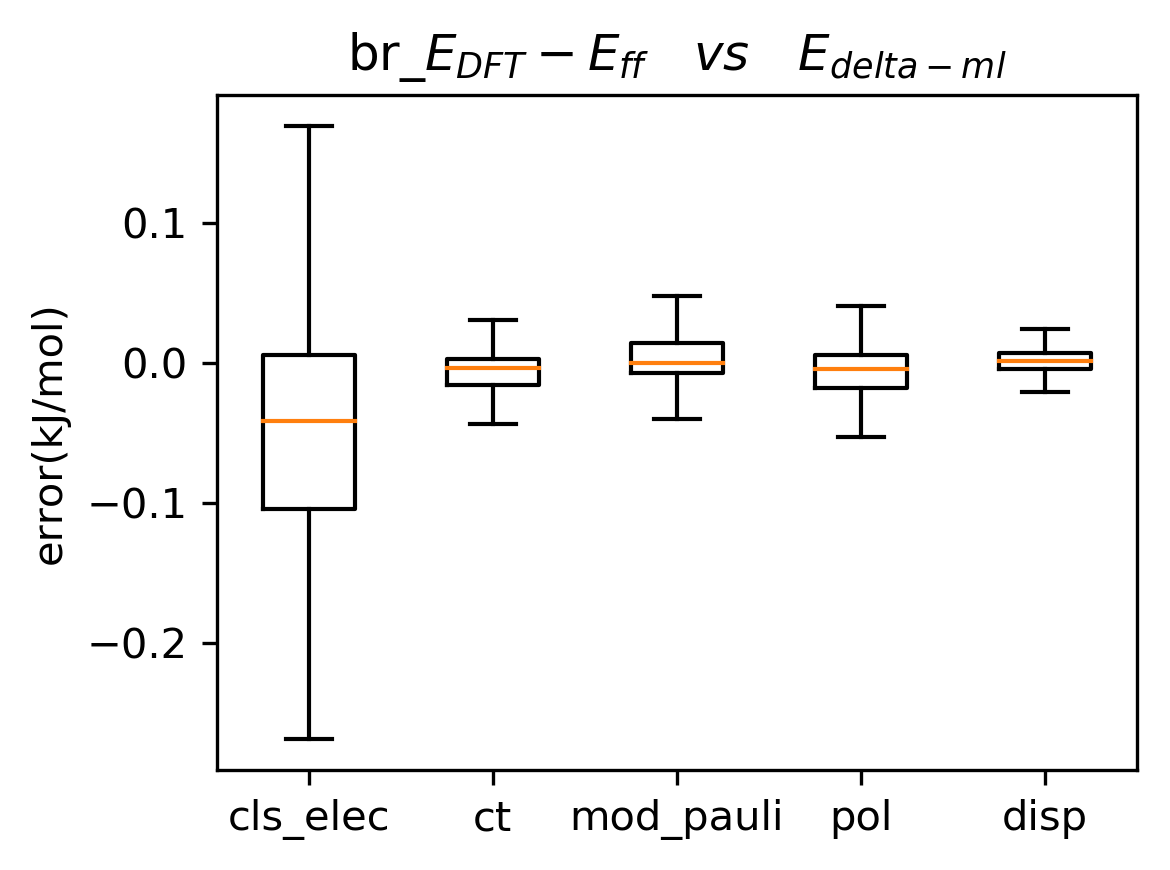

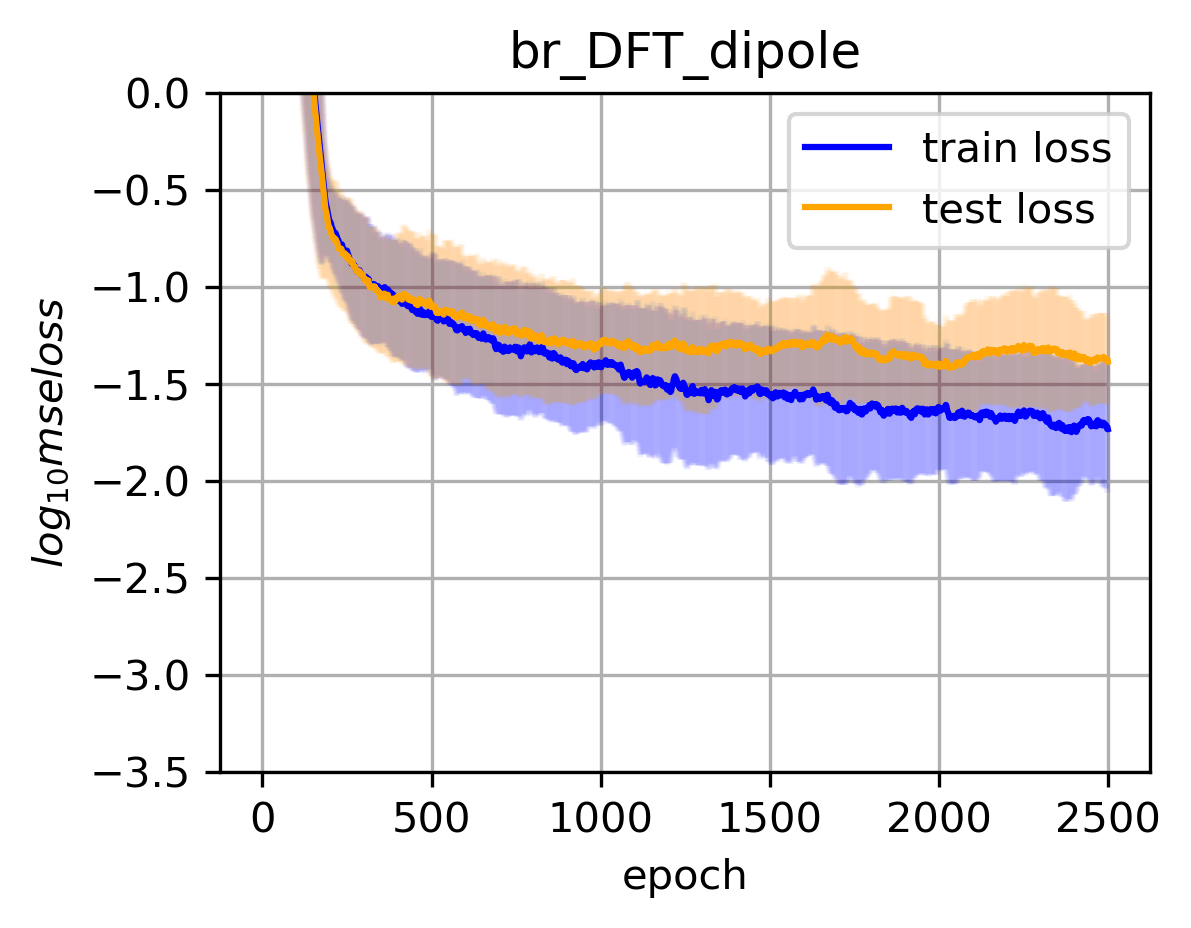

In [5]:
file_path = 'args.txt'  # Replace with the path to text file
ele, model_struc, epochs = load_config_values(file_path)
print(ele)

label_type = 'eda_dipole'

save_path = label_type +'/'

filepath_sobol = '/global/home/users/yifancui/delta-ml/dataset_v1.0/xyz/h2o_'+ele+'_sobol.xyz'
filepath_aimd = '/global/home/users/yifancui/delta-ml/dataset_v1.0/xyz/h2o_'+ele+'_aimd.xyz'
xyz_sobol = load_xyz(filepath_sobol)
xyz_aimd = load_xyz(filepath_aimd)
xyz = np.concatenate((xyz_sobol,xyz_aimd),axis=0)


##   SOBOL + AIMD

label = ['cls_elec','ct','mod_pauli','pol','disp']

E_eda_sobol = pd.read_csv('/global/home/users/yifancui/delta-ml/dataset_v1.0/eda_labels/h2o_'+ele+'_sobol.csv')[label]
E_eda_aimd = pd.read_csv('/global/home/users/yifancui/delta-ml/dataset_v1.0/eda_labels/h2o_'+ele+'_aimd.csv')[label]

if label_type == 'eda_aniso':
    E_aniso_sobol = pd.read_csv('/global/home/users/yifancui/delta-ml/dataset_v1.0/ff_aniso_labels/h2o_'+ele+'_sobol_ff_aniso.csv')[label]
    E_aniso_aimd = pd.read_csv('/global/home/users/yifancui/delta-ml/dataset_v1.0/ff_aniso_labels/h2o_'+ele+'_aimd_ff_aniso.csv')[label]
    E = np.concatenate((E_eda_sobol-E_aniso_sobol,E_eda_aimd-E_aniso_aimd),axis=0)
    label_type = 'DFT_aniso'

if label_type  == 'eda_dipole':
    E_dipole_sobol = pd.read_csv('/global/home/users/yifancui/delta-ml/dataset_v1.0/ff_dipole_labels/h2o_'+ele+'_sobol_ff_dipole.csv')[label]
    E_dipole_aimd = pd.read_csv('/global/home/users/yifancui/delta-ml/dataset_v1.0/ff_dipole_labels/h2o_'+ele+'_aimd_ff_dipole.csv')[label]
    E = np.concatenate((E_eda_sobol-E_dipole_sobol,E_eda_aimd-E_dipole_aimd),axis=0)
    label_type = 'DFT_dipole'
    
if label_type  == 'eda':
    E = np.concatenate((E_eda_sobol,E_eda_aimd),axis=0)
    
    
# select 5000 data points not included in the training set
size = len(xyz)
indices = list(range(size))
random.shuffle(indices)
train_indices = np.loadtxt(save_path+ 'train_indices.txt').tolist()
test_indices = list(set(indices)-set(train_indices))
random.shuffle(test_indices)
test_indices = test_indices[:10000]

xyz_test, E_test = xyz[test_indices], E[test_indices]
dist_all = np.array([dist(x) for x in xyz_test],dtype=np.float16)
dist_ion_water = dist_all[:,0,3]

hyb_test = hyb_n(xyz_test)
x_test = torch.tensor(hyb_test)
x_test = x_test.view(10000,16)
x_test = x_test.to(torch.float32)




device = torch.device('cpu')
model = torch.load(save_path+"best_model.pt",map_location=torch.device('cpu'))
model.to(device)
model.eval()
x_test = x_test.to(device)
output = model(x_test)
output_numpy = output.detach().numpy()

for i in range(5):
    plt.figure(figsize = (4,3),dpi=600)
    plt.scatter(dist_ion_water,output_numpy[:,i],s=0.3,alpha=0.7,label=r'$E_{delta-ml}$')
    plt.scatter(dist_ion_water,E_test[:,i],s=0.3,alpha=0.3,label=r'$E_{DFT}-E_{ff(dipole)}$')
    plt.xlabel(r'$r(\AA)$')
    plt.ylabel('E(kJ/mol)')
    plt.legend(loc='best',markerscale=6)
    
    if i ==0:
        plt.title(label_type+'_cls_elec_'+ele)
        plt.tight_layout()
        plt.savefig(save_path+ele+'_'+label_type+'_cls_elec_r.jpg')
    if i ==1:
        plt.title(label_type+'_ct_'+ele)
        plt.tight_layout()
        plt.savefig(save_path+ele+'_'+label_type+'_ct_r.jpg')
    if i ==2:
        plt.title(label_type+'_mod_pauli_'+ele)
        plt.tight_layout()
        plt.savefig(save_path+ele+'_'+label_type+'_mod_pauli_r.jpg')
    if i ==3:
        plt.title(label_type+'_pol_'+ele)
        plt.tight_layout()
        plt.savefig(save_path+ele+'_'+label_type+'_pol_r.jpg')
    if i ==4:
        plt.title(label_type+'_disp_'+ele)
        plt.tight_layout()
        plt.savefig(save_path+ele+'_'+label_type+'_disp_r.jpg')
        
        
plot_scatter(E_test[:,0],output_numpy[:,0],save_path,ele+'_'+label_type+'_cls_elec')
plot_scatter(E_test[:,1],output_numpy[:,1],save_path,ele+'_'+label_type+'_ct')
plot_scatter(E_test[:,2],output_numpy[:,2],save_path,ele+'_'+label_type+'_mod_pauli')
plot_scatter(E_test[:,3],output_numpy[:,3],save_path,ele+'_'+label_type+'_pol')
plot_scatter(E_test[:,4],output_numpy[:,4],save_path,ele+'_'+label_type+'_disp')
plot_box((E_test-output_numpy),save_path,ele,label_type)

E_test_eda_dipole = E_test
E_dml_eda_dipole = output_numpy


train_loss = np.loadtxt(save_path+'Train_mseloss_1.txt')
test_loss = np.loadtxt(save_path+'Test_mseloss_1.txt')
fig, axs = plt.subplots(1, 1,figsize=(4,3),dpi=300)

plot_mean_with_errorbars( np.arange(len(train_loss)),np.log10(train_loss), 100, 50,'blue',axs,label = 'train loss')
plot_mean_with_errorbars( np.arange(len(test_loss)),np.log10(test_loss), 100, 50,'orange',axs,label = 'test loss')

axs.set_xlabel('epoch')
axs.set_ylabel(r'$log_{10}mseloss$')
axs.set_title(ele+'_'+label_type)
axs.set_ylim(-3.5,0)
fig.savefig(save_path+ele+'_'+label_type+'_train_test.jpg')

# eda 

br


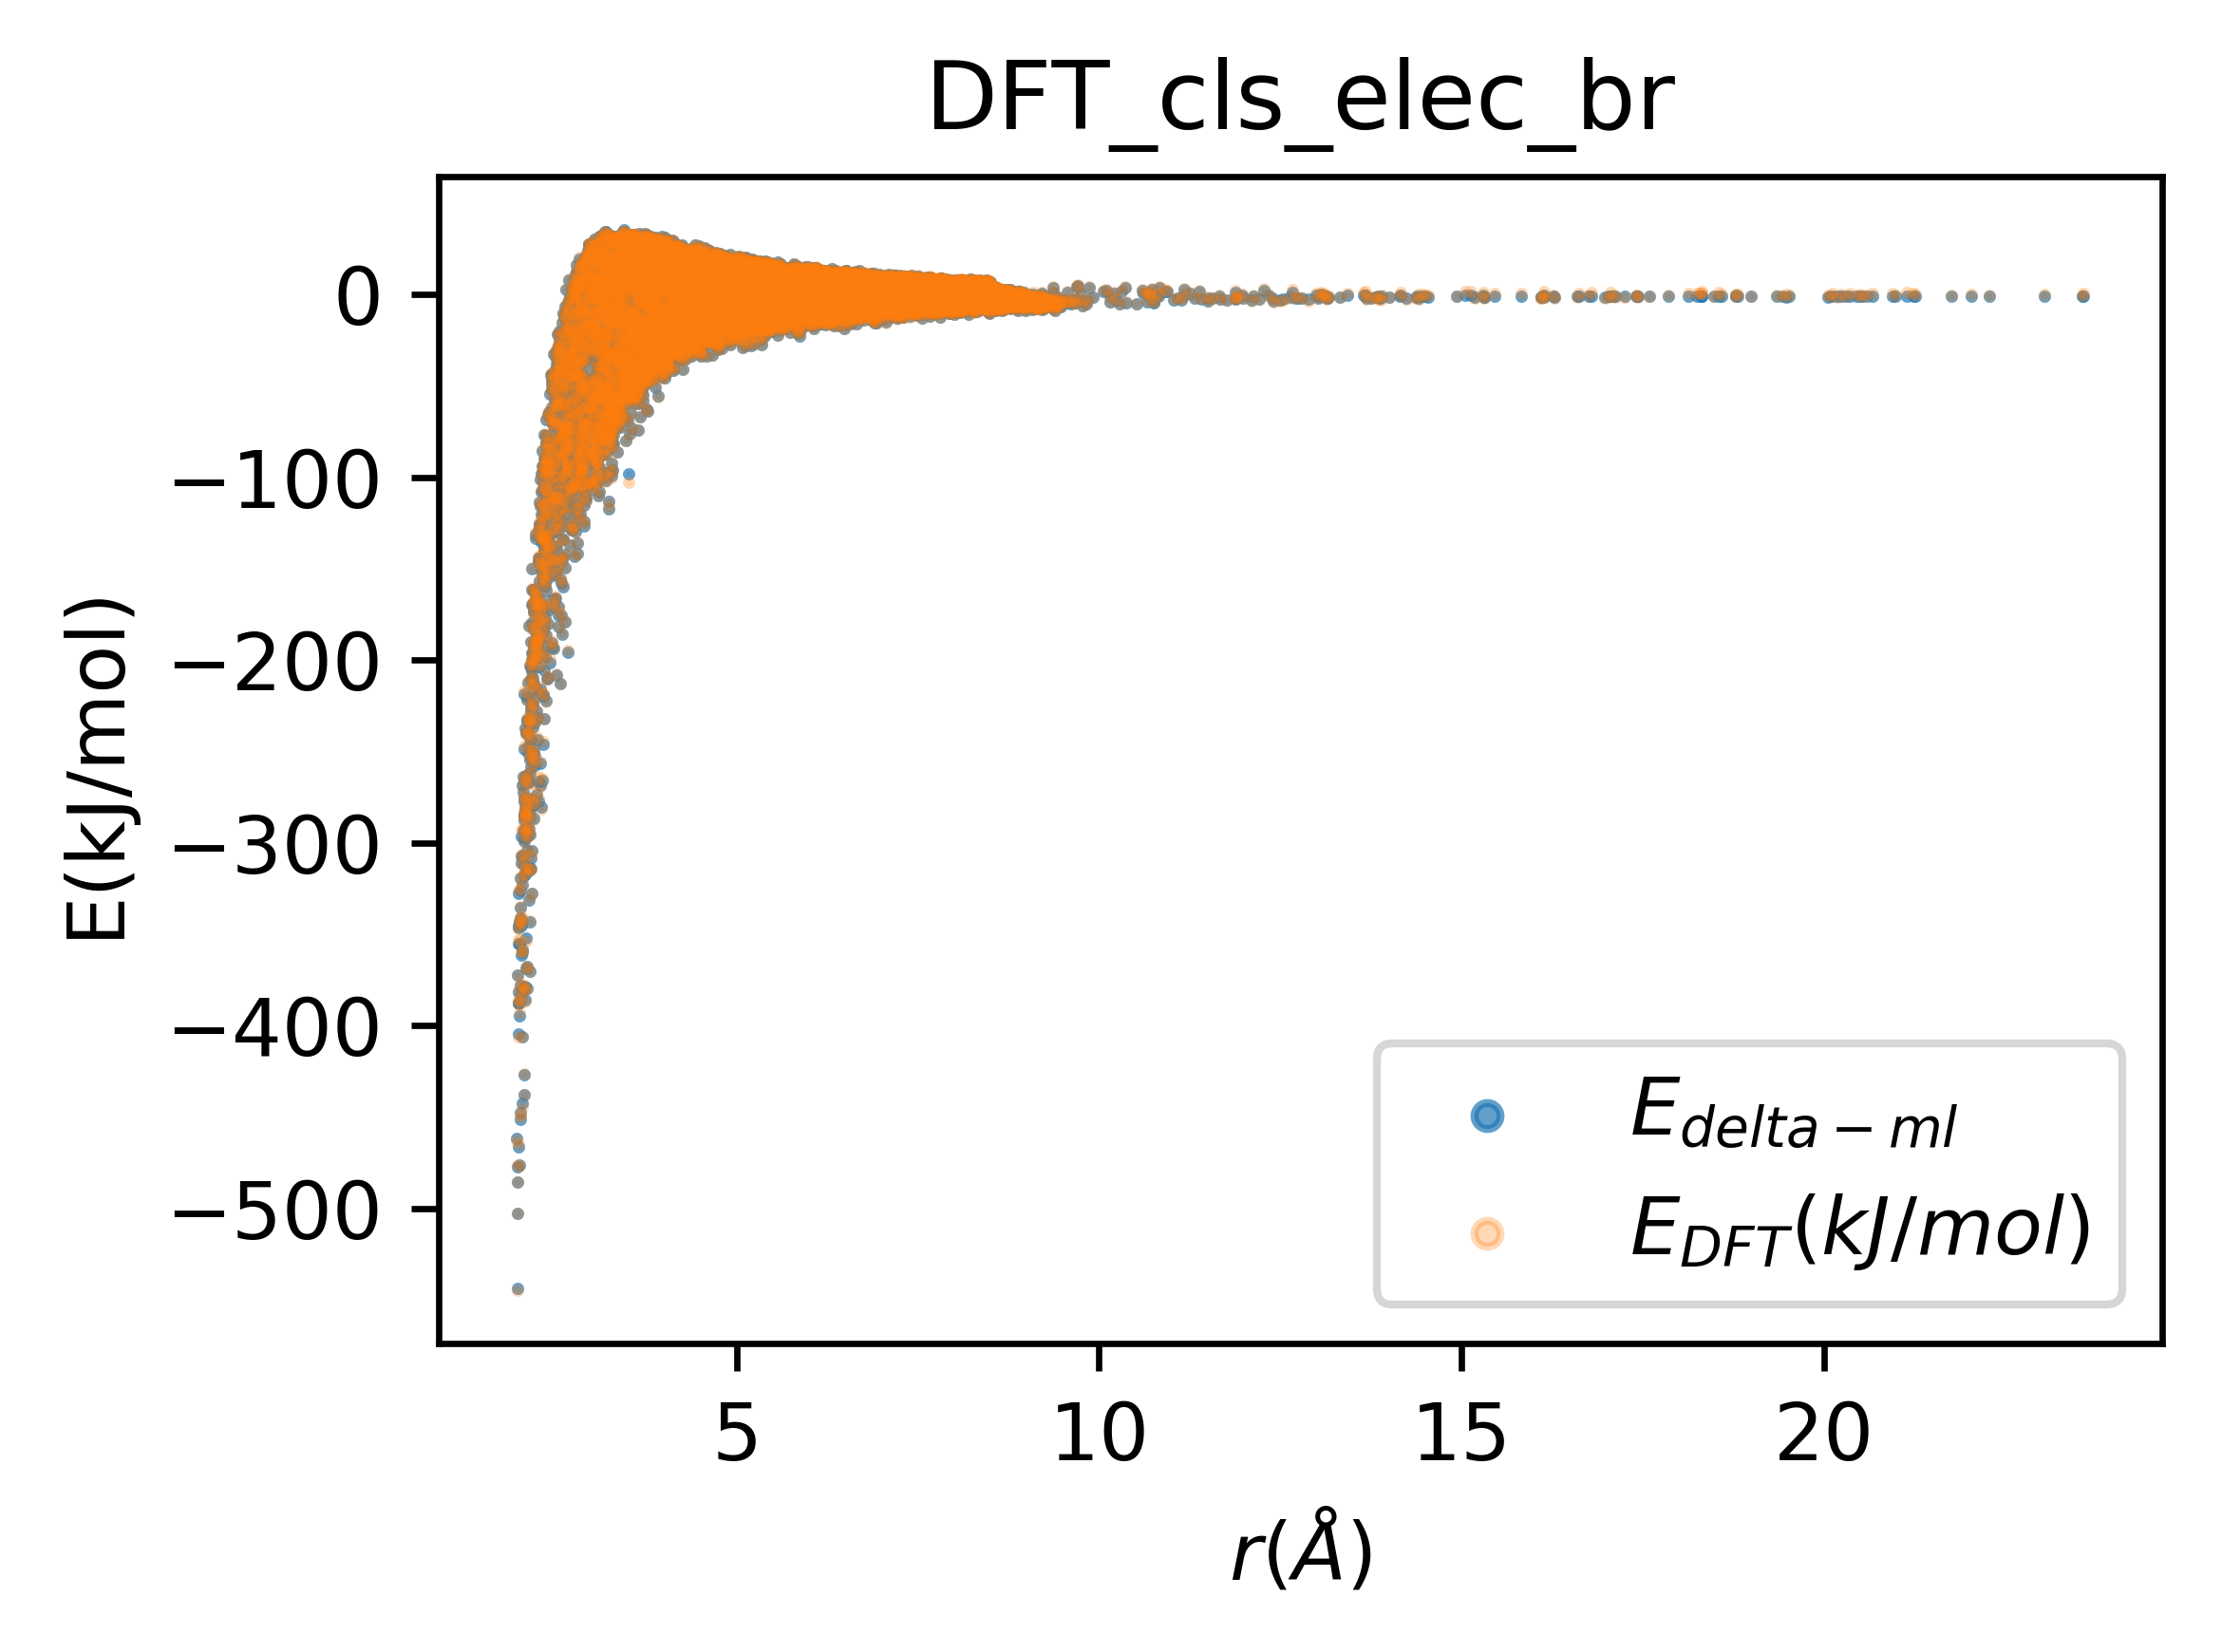

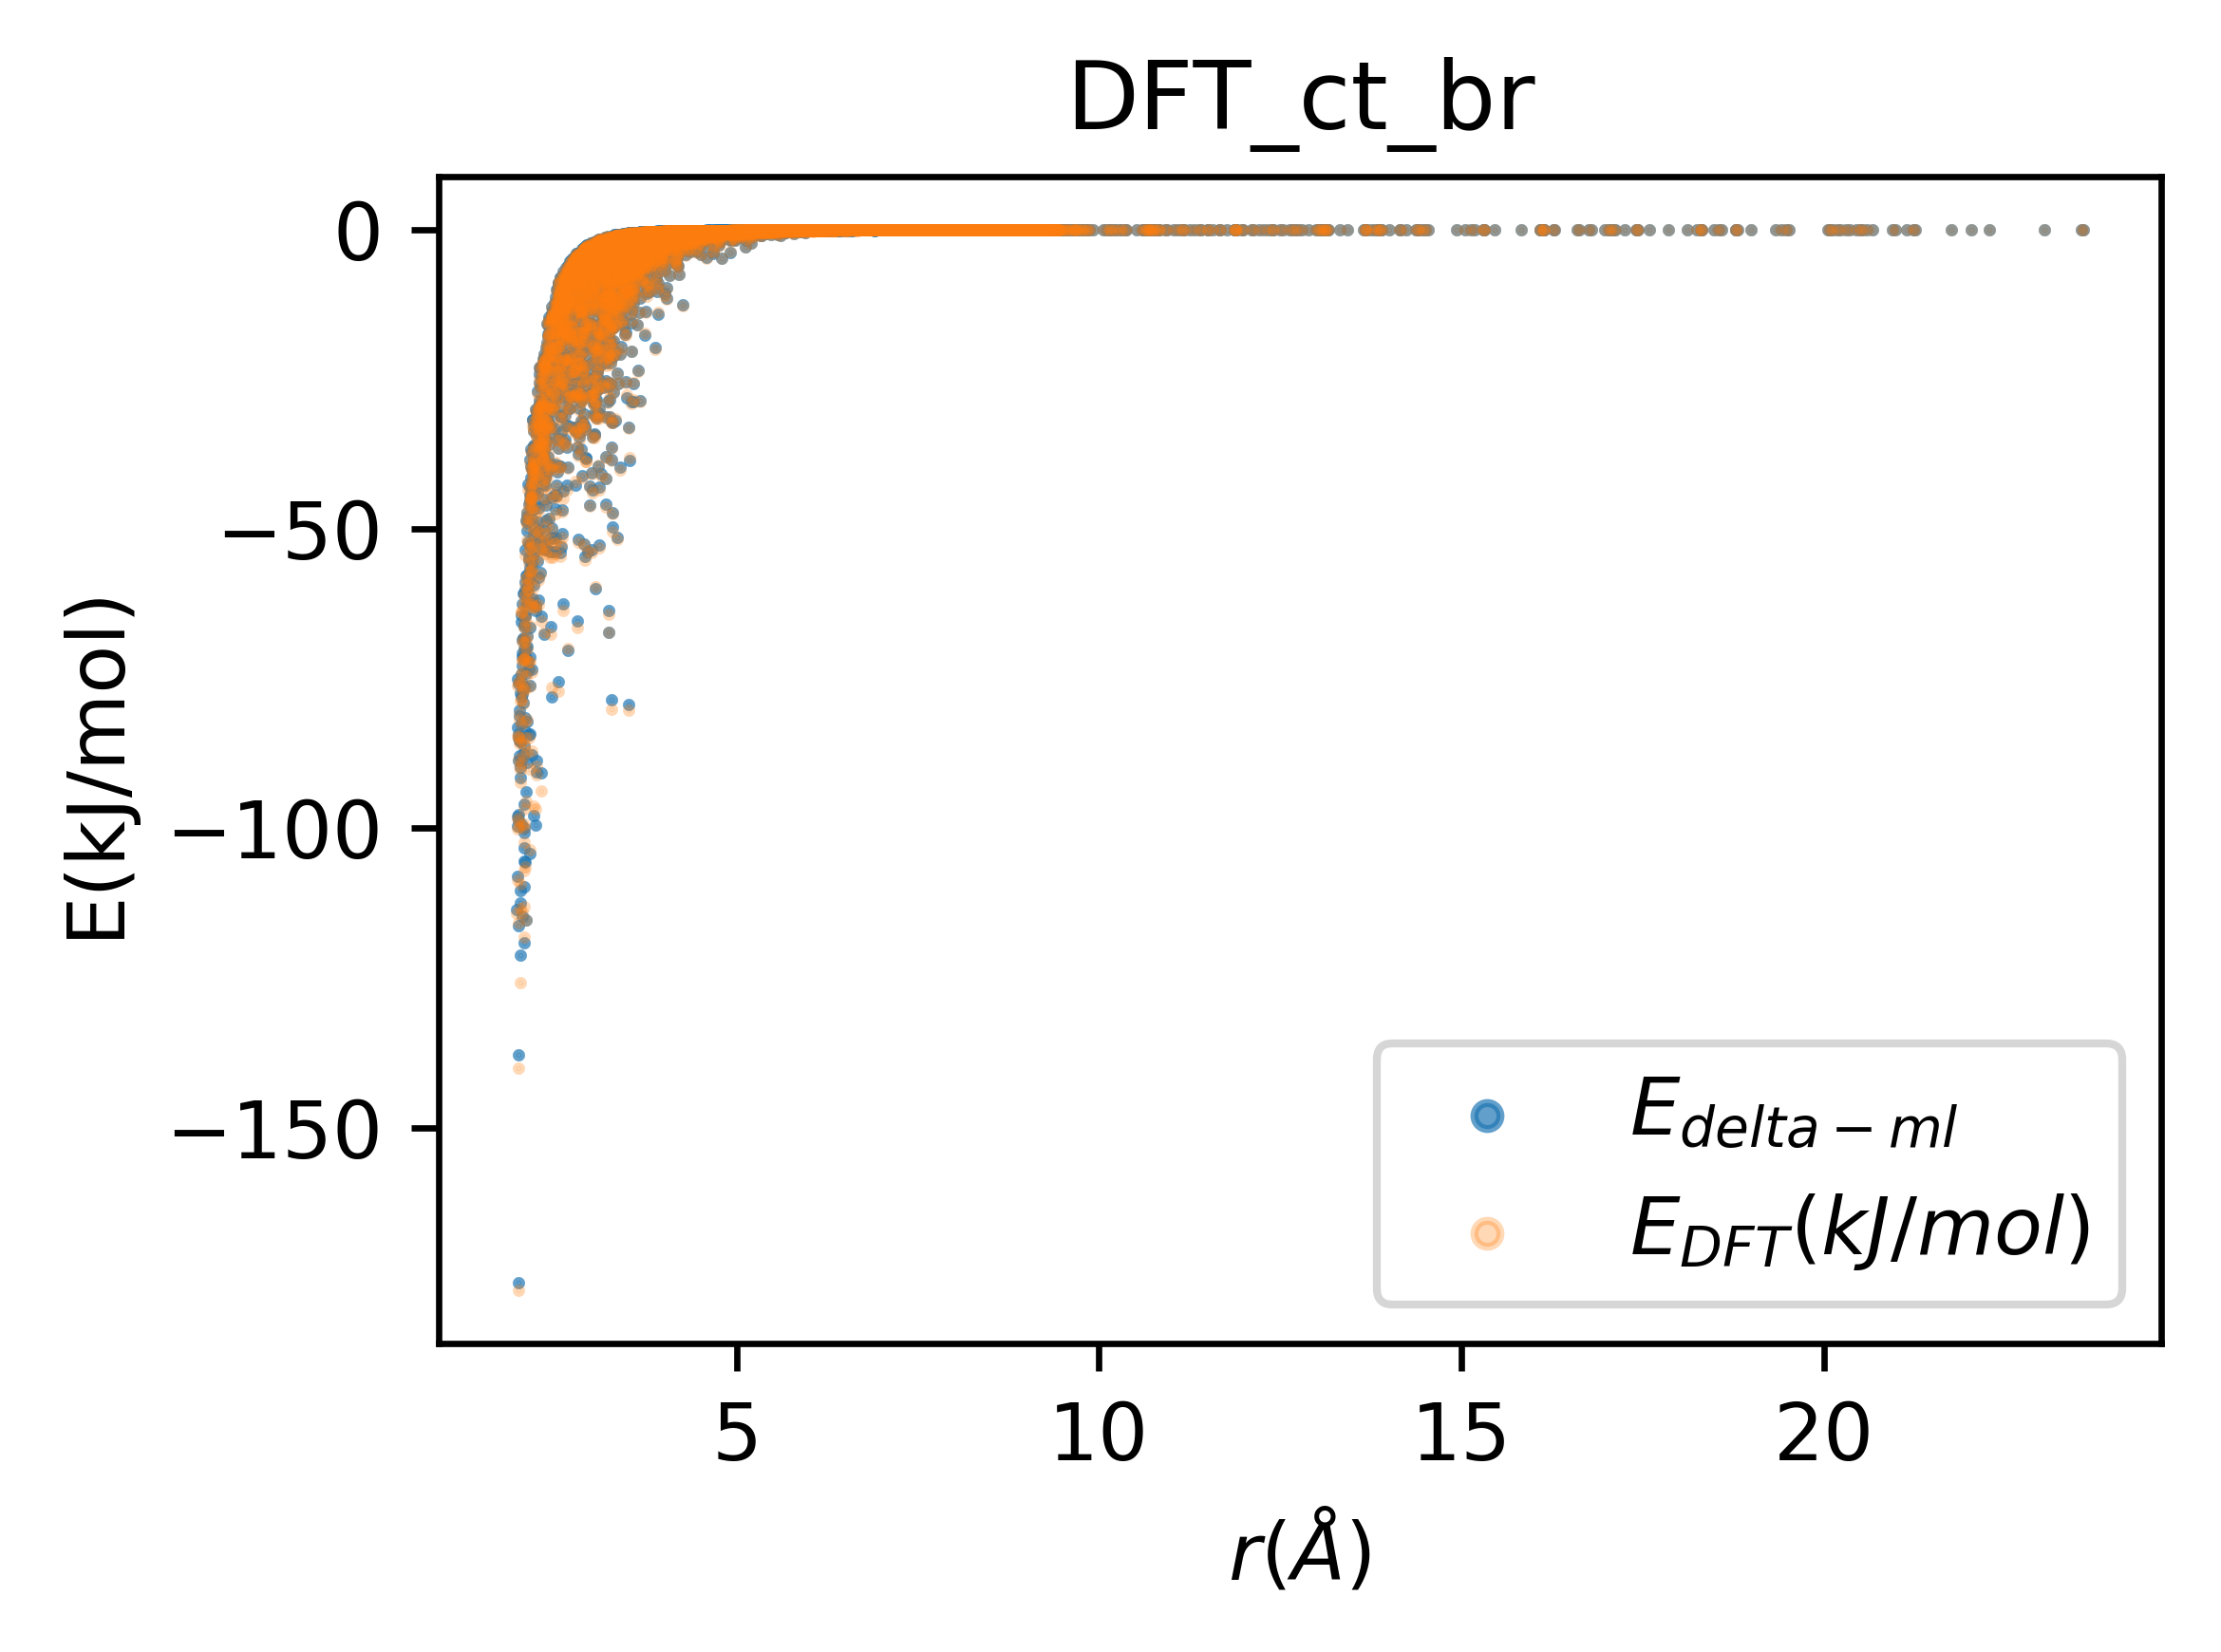

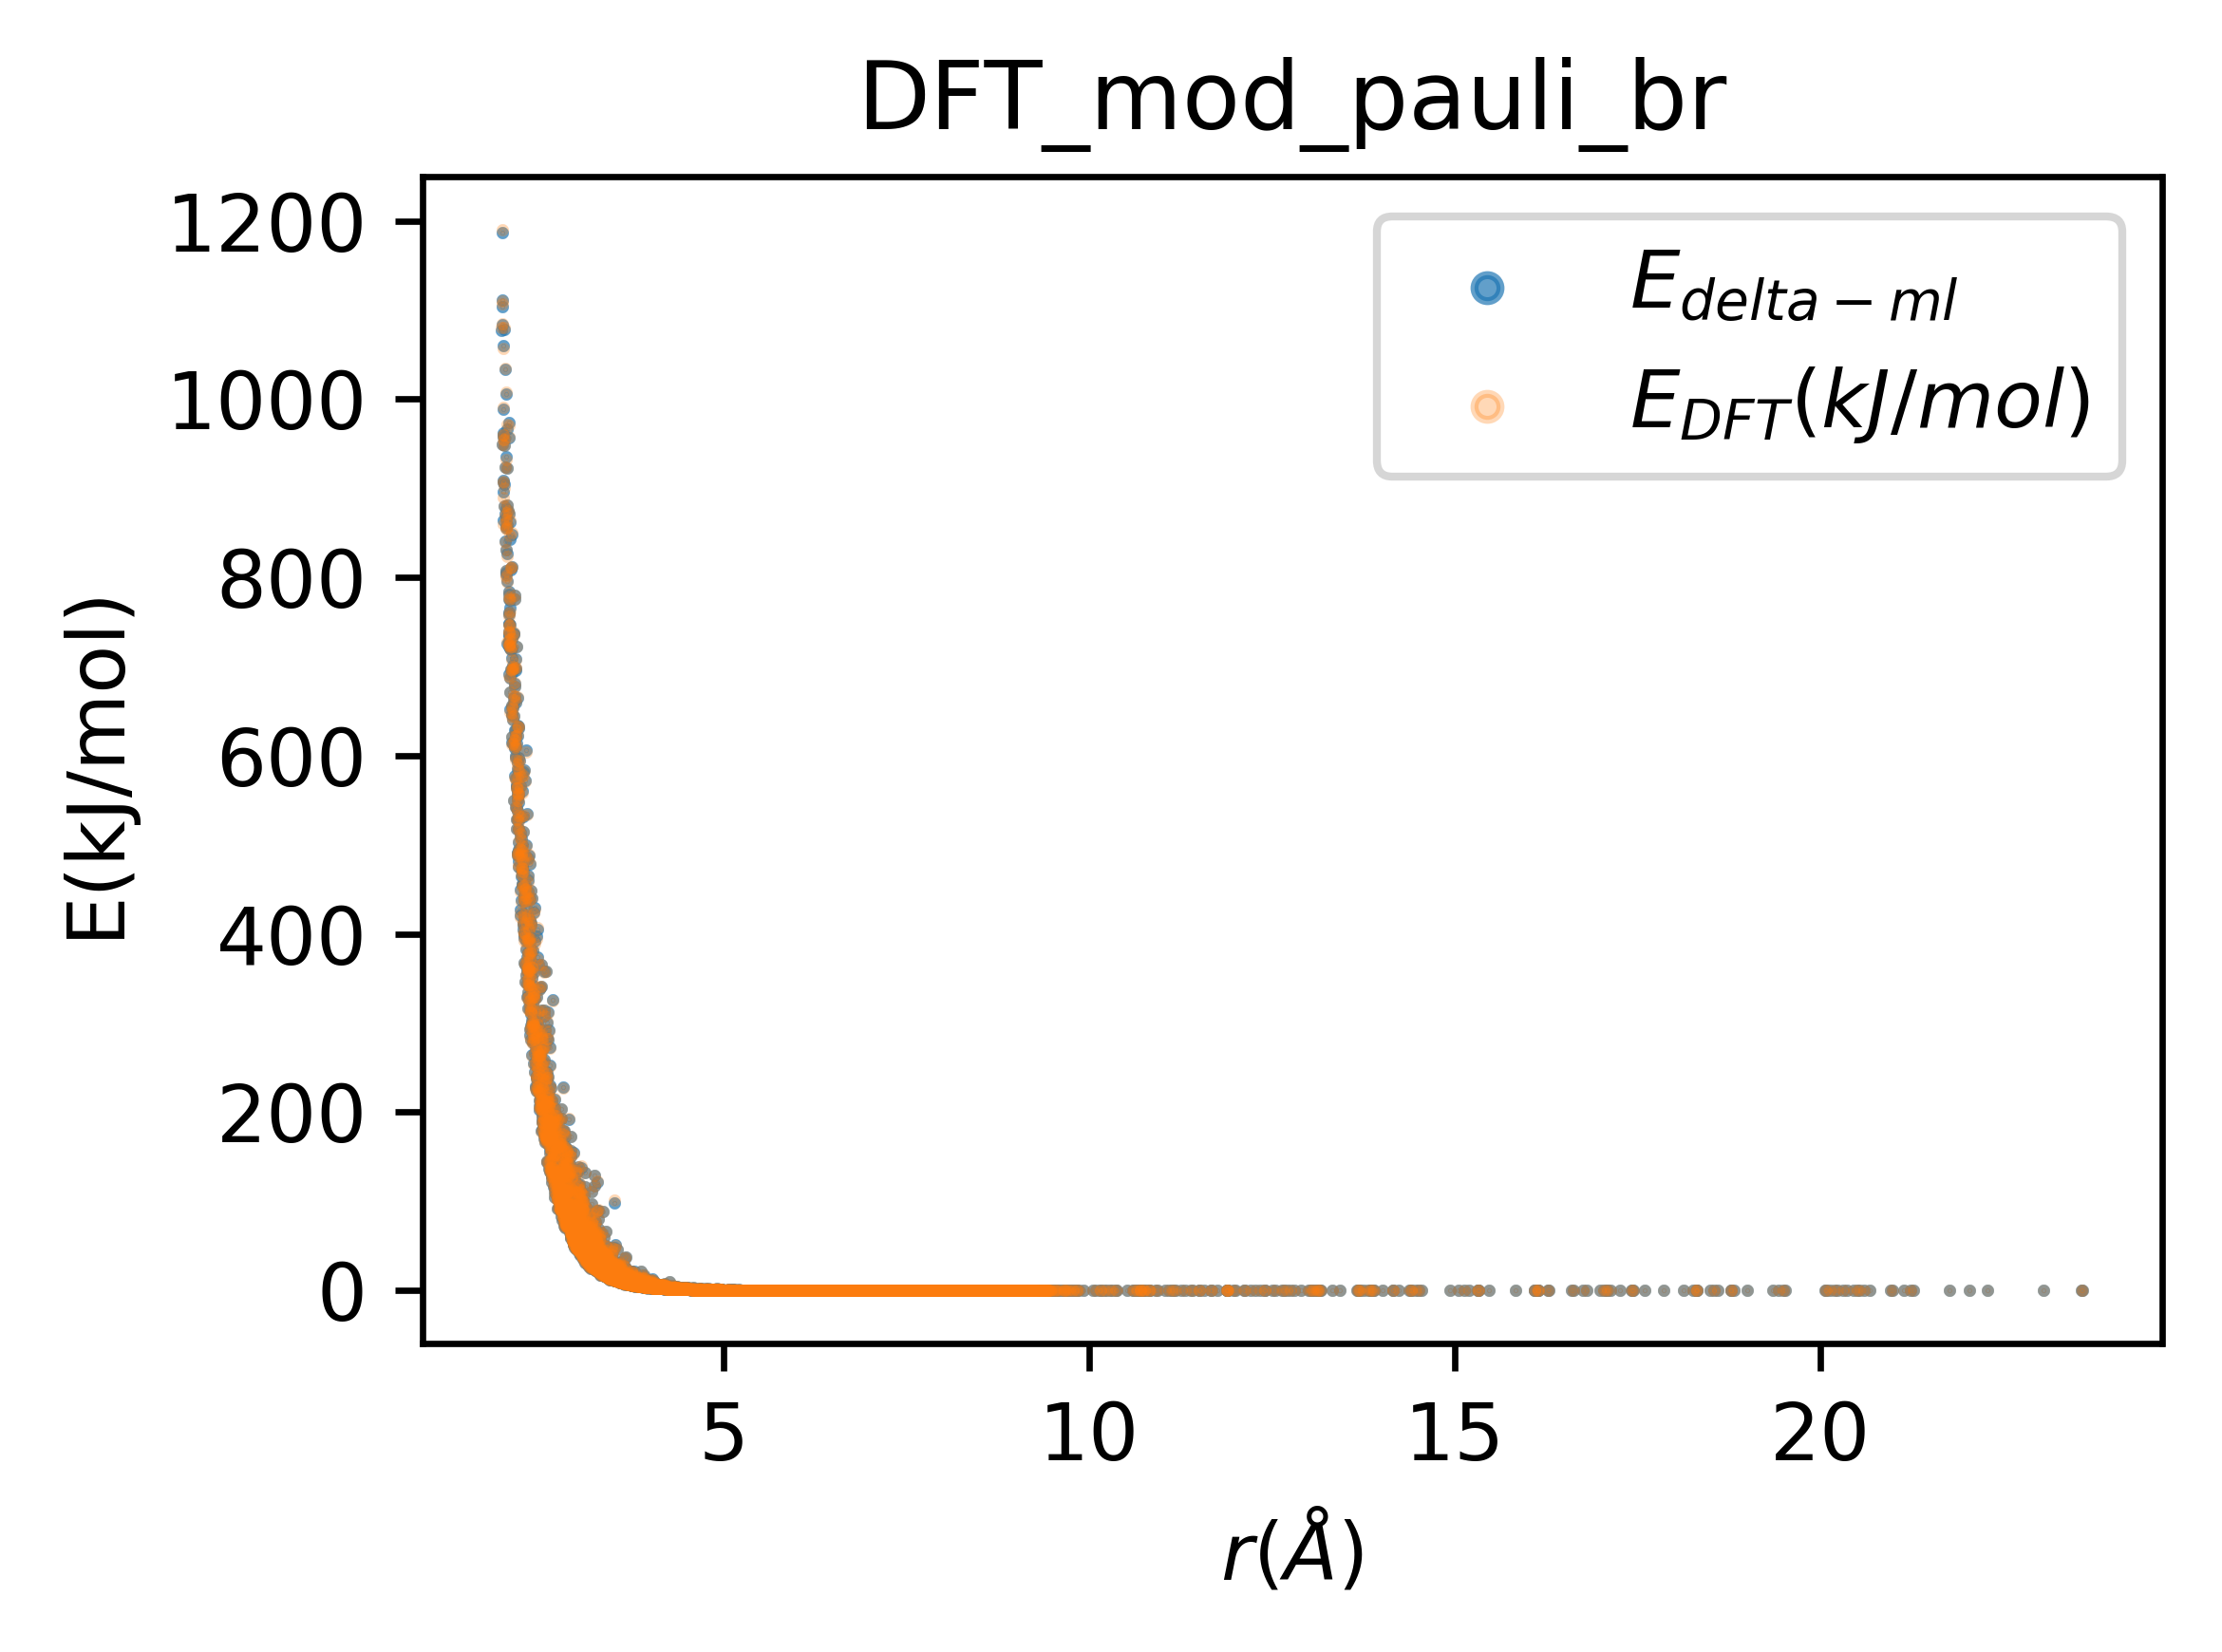

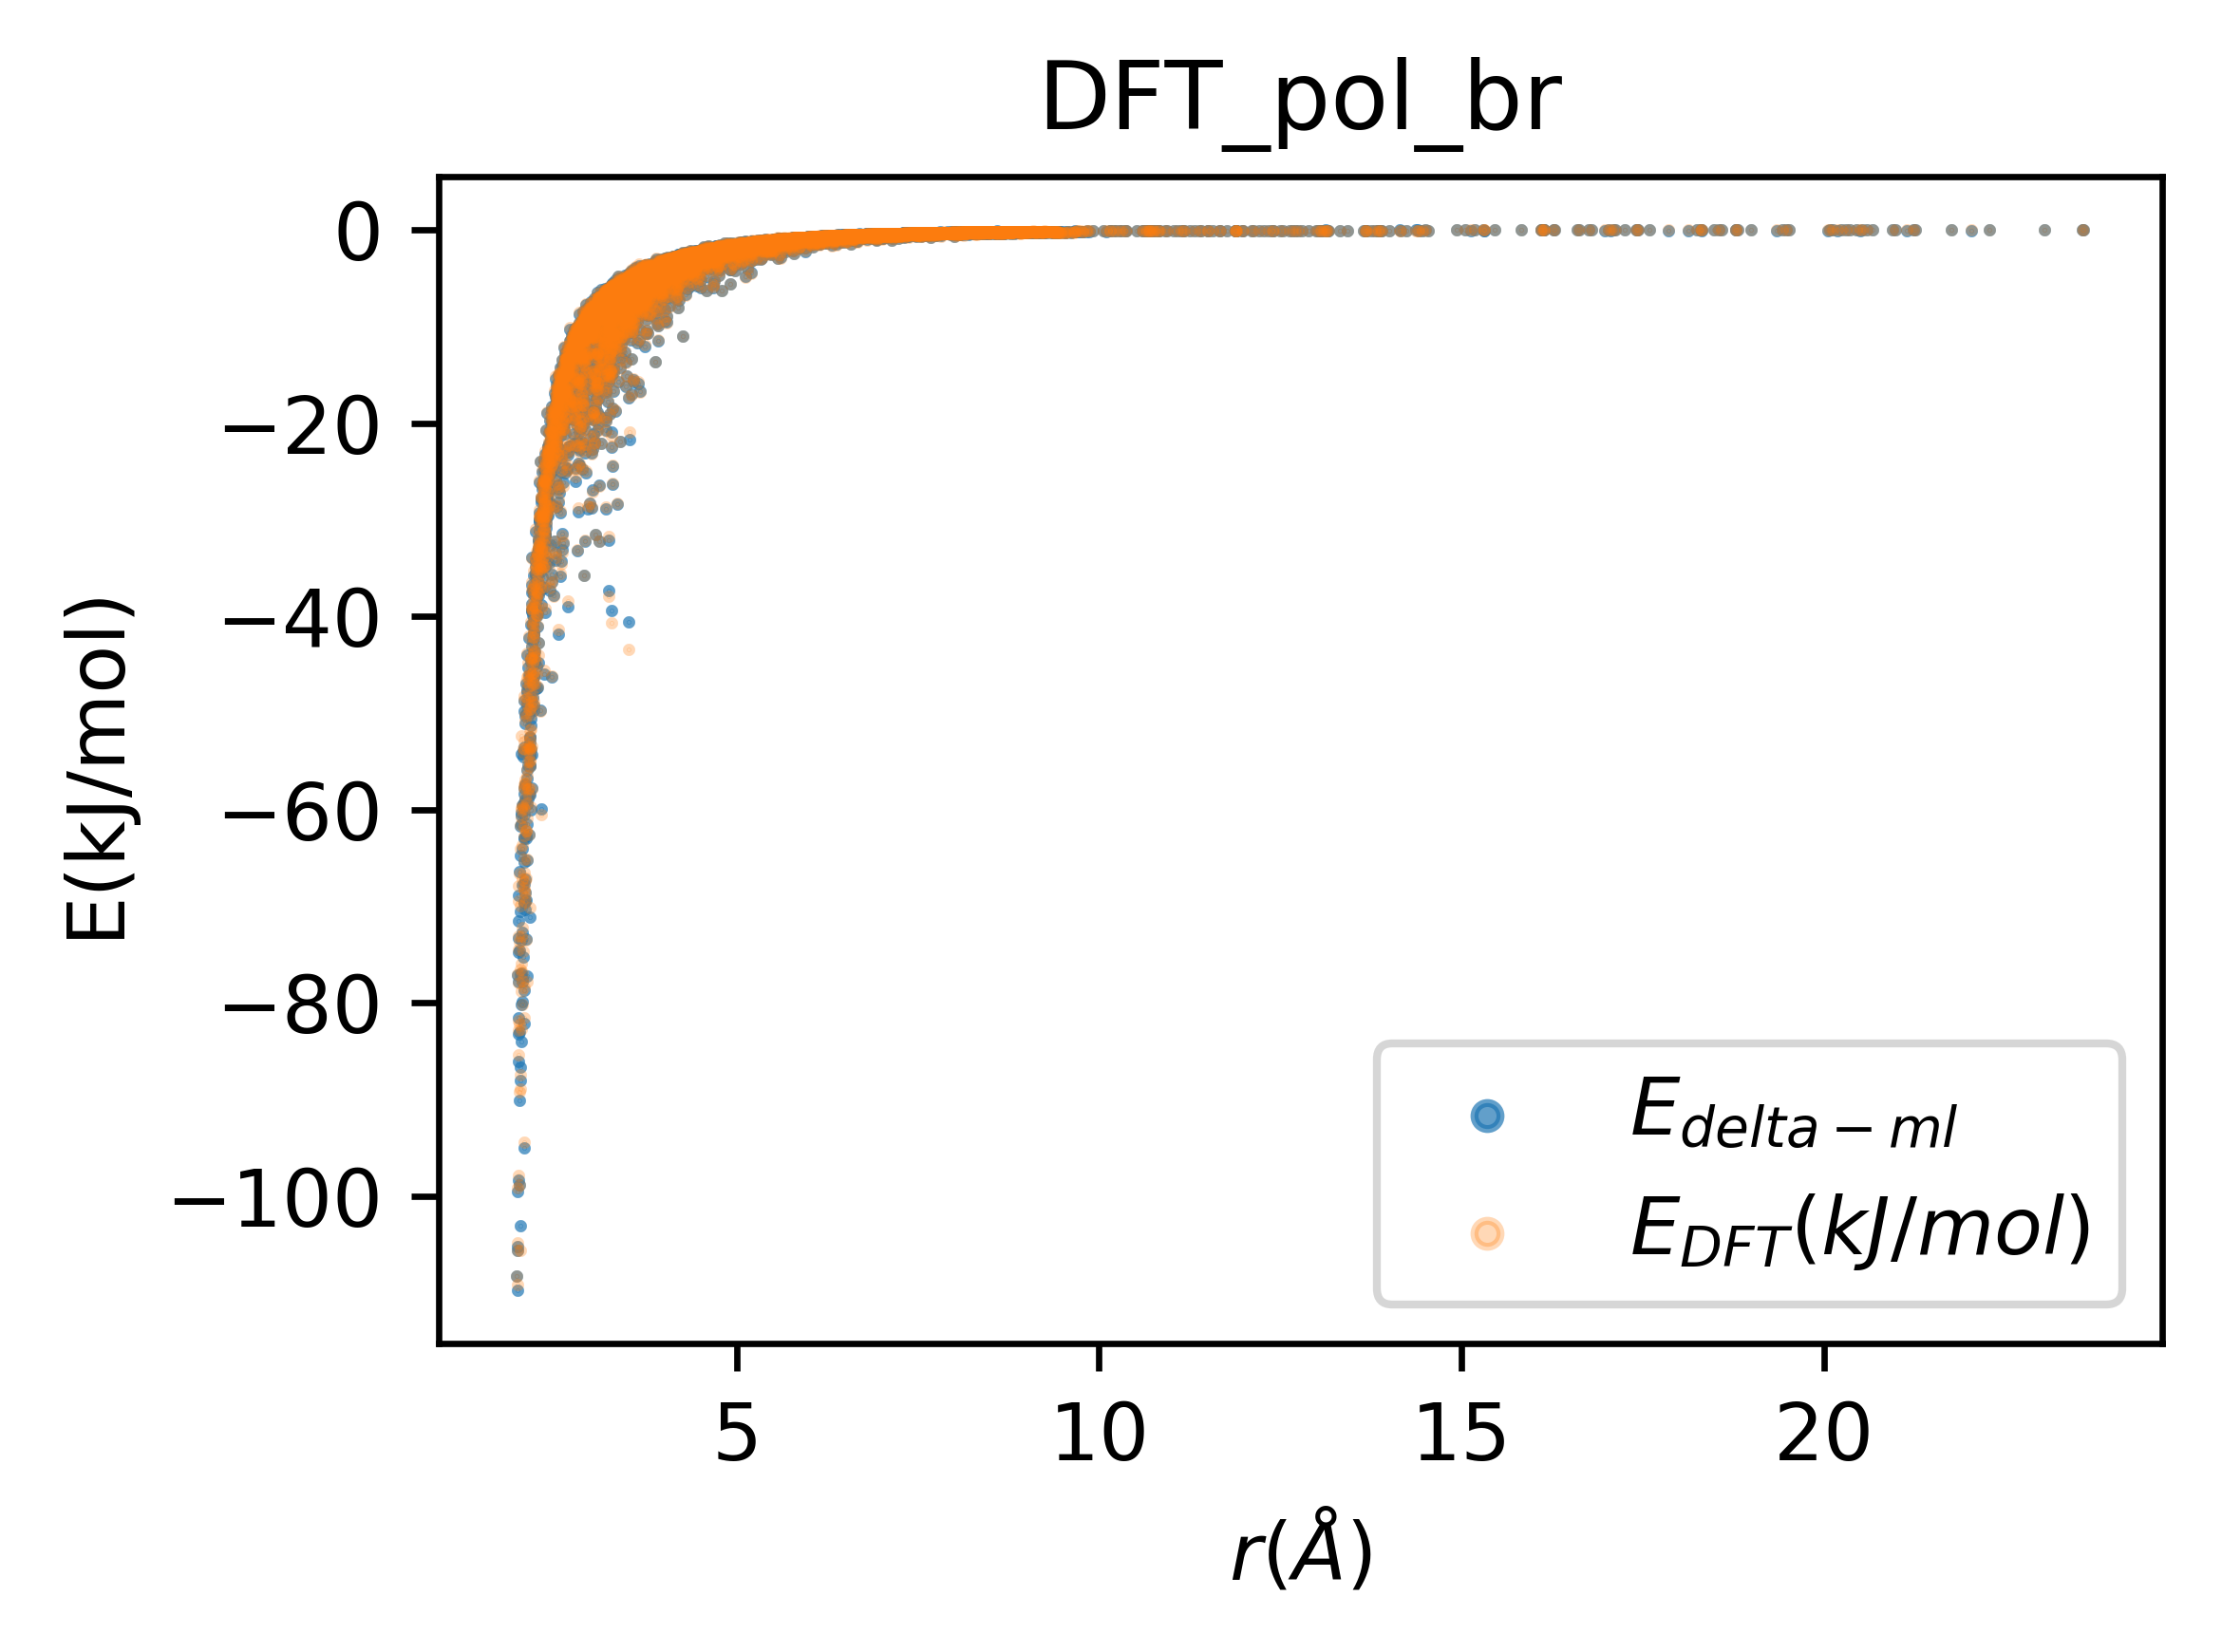

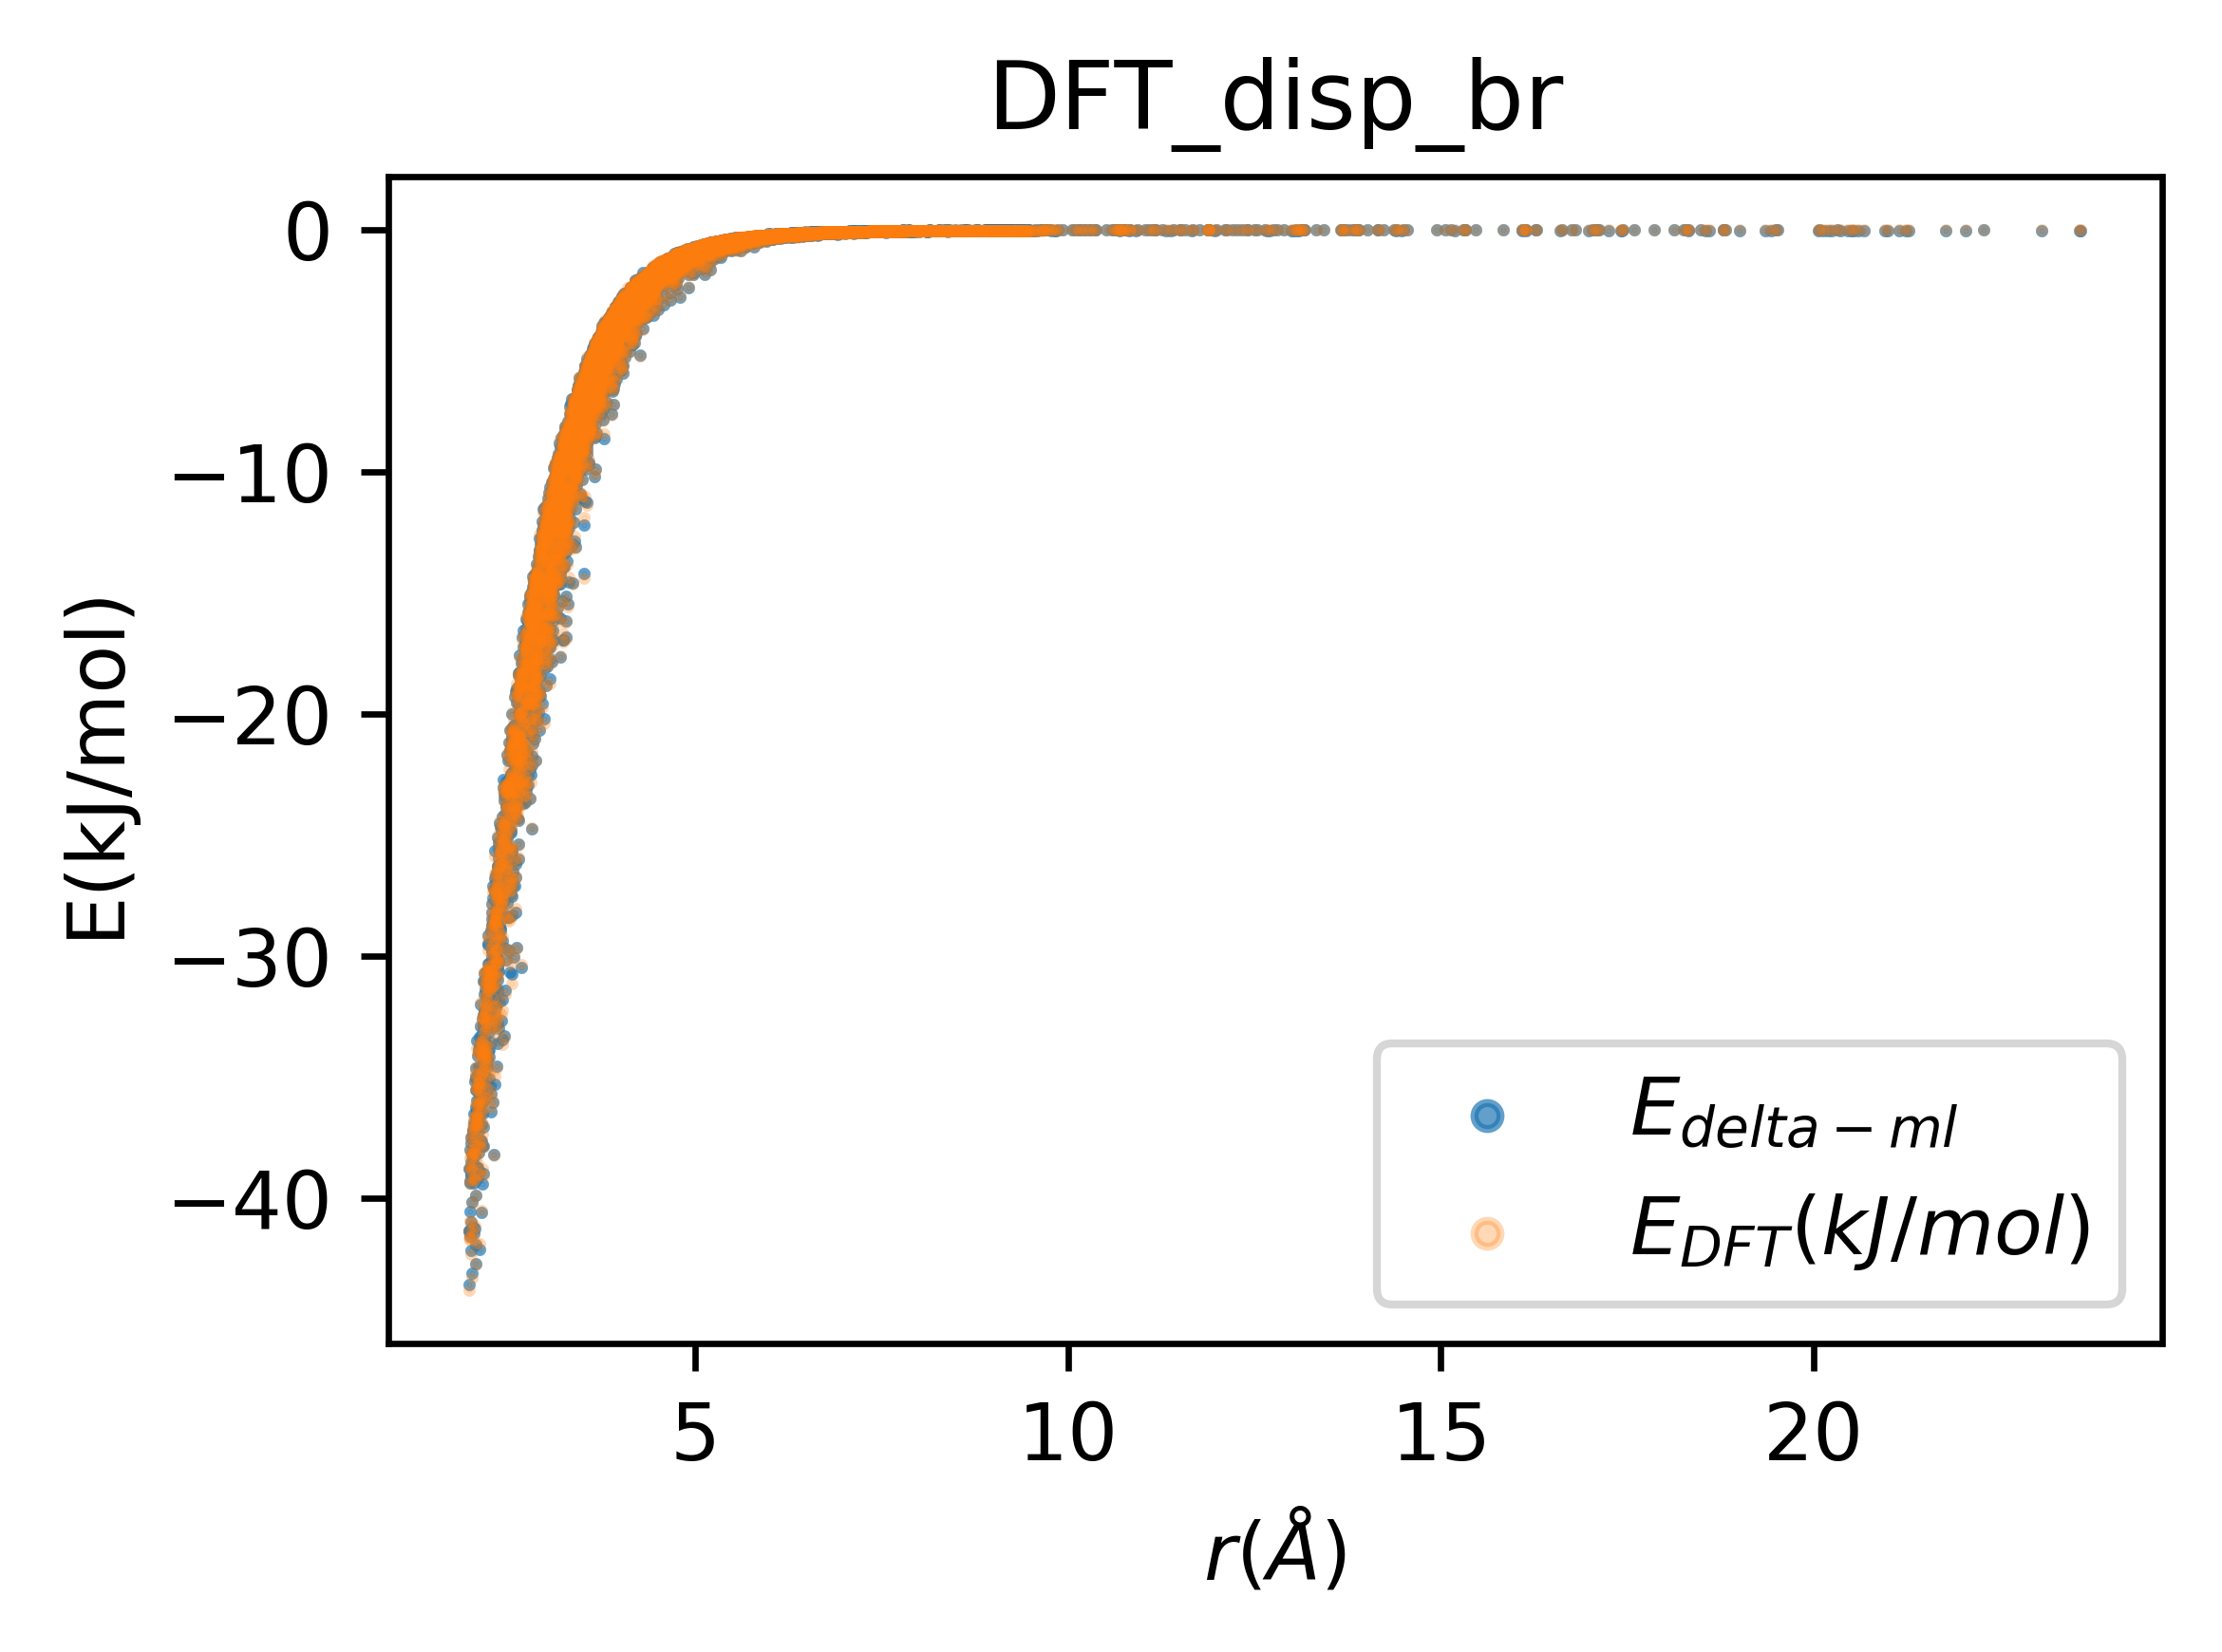

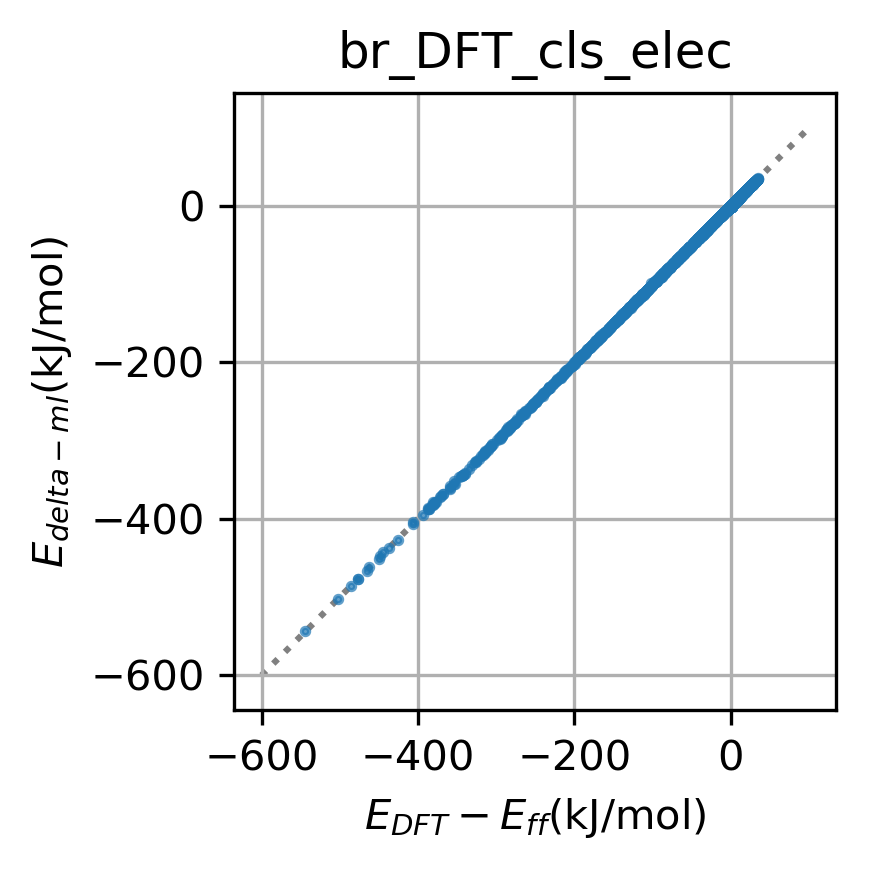

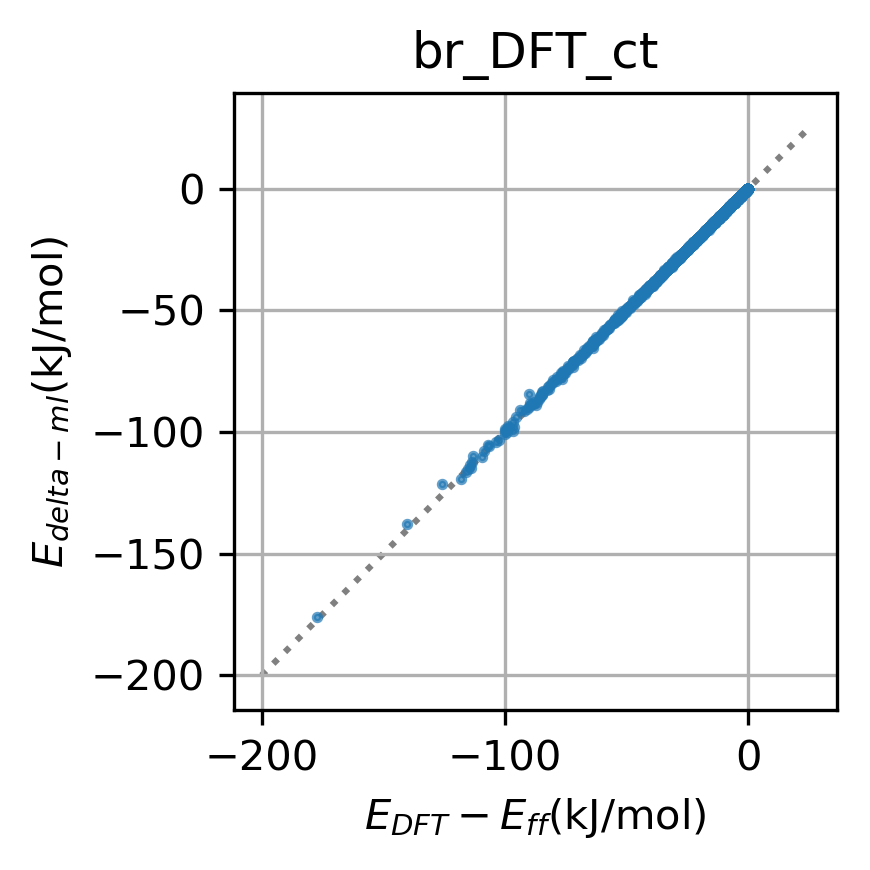

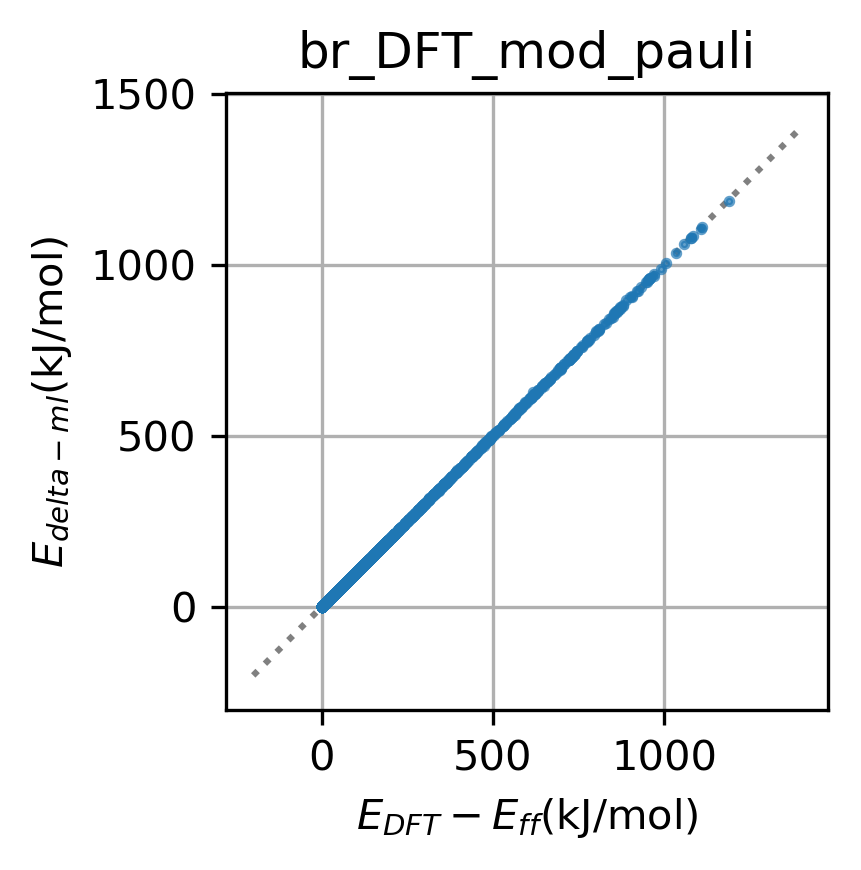

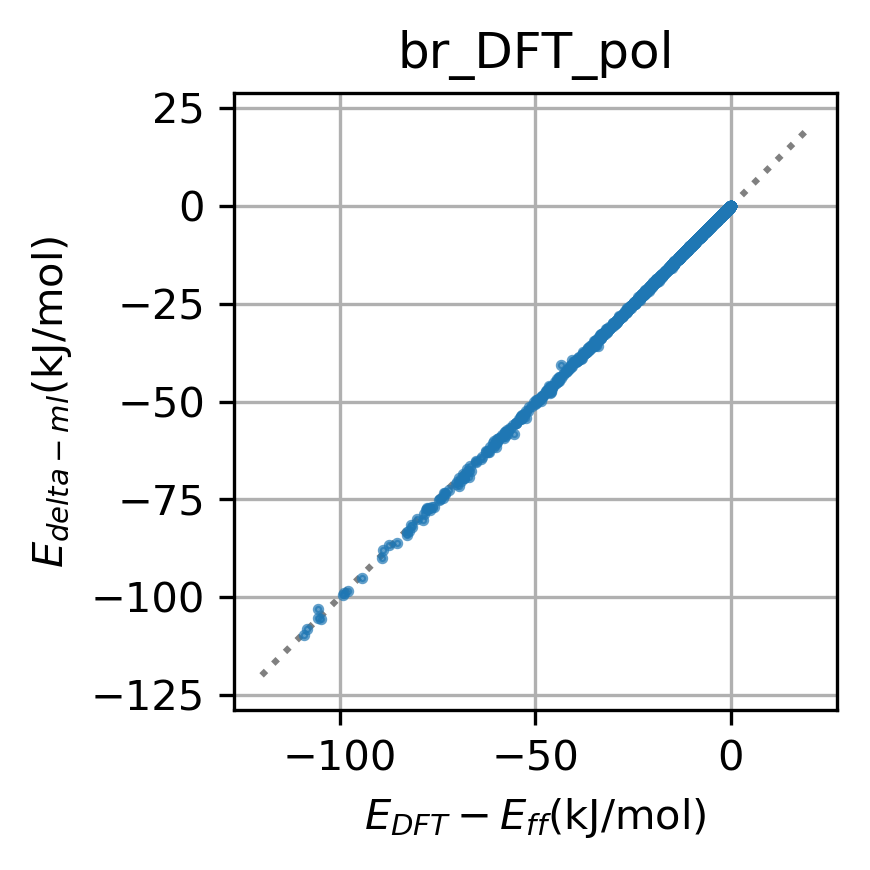

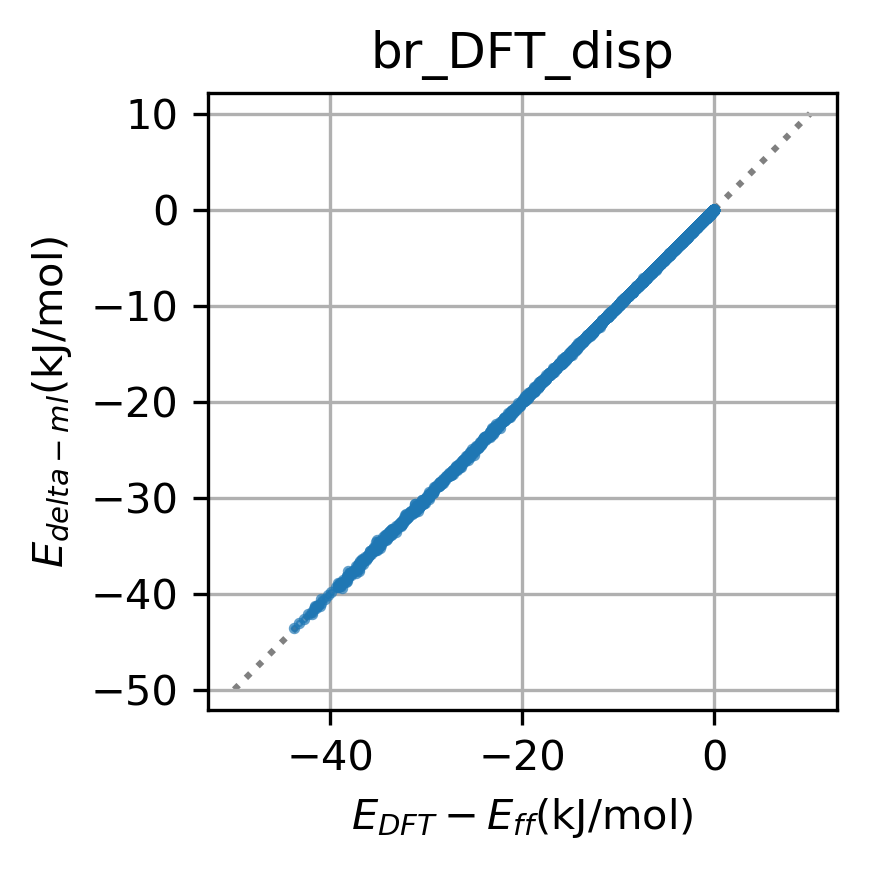

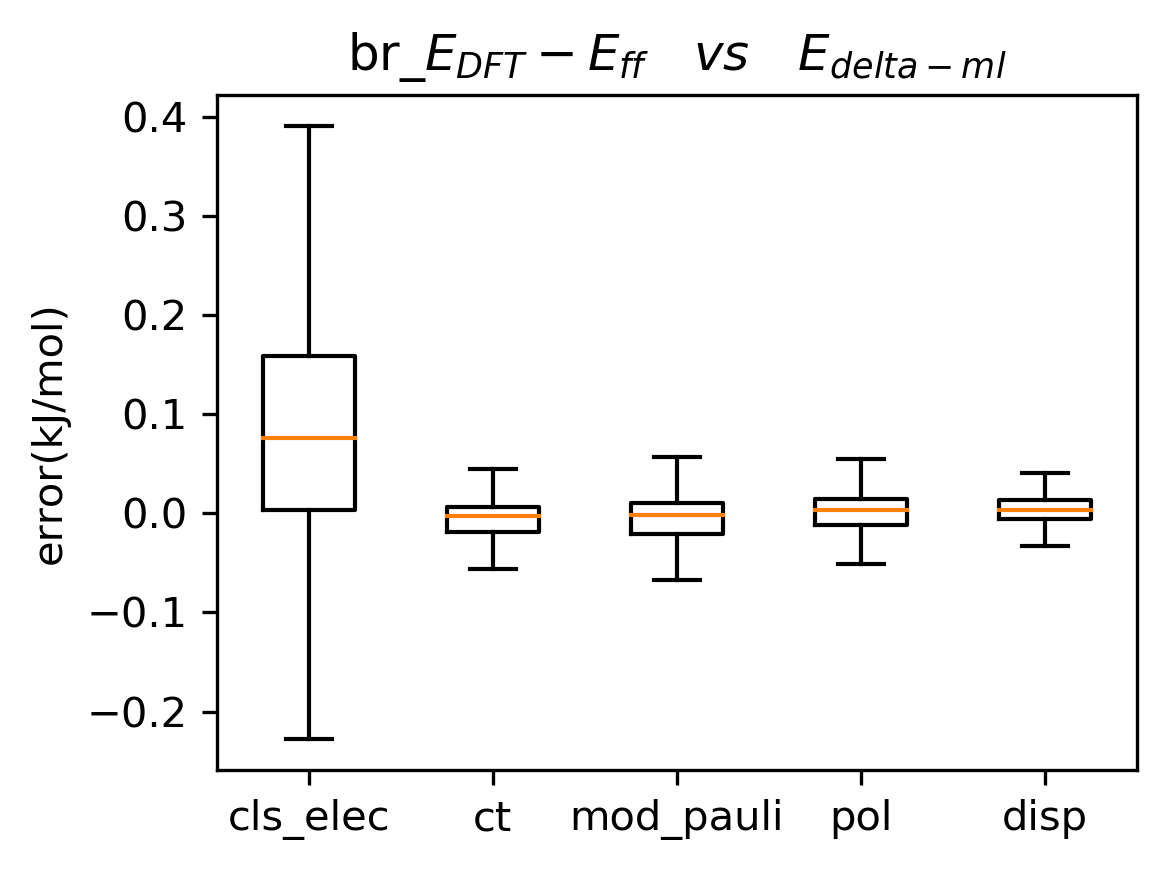

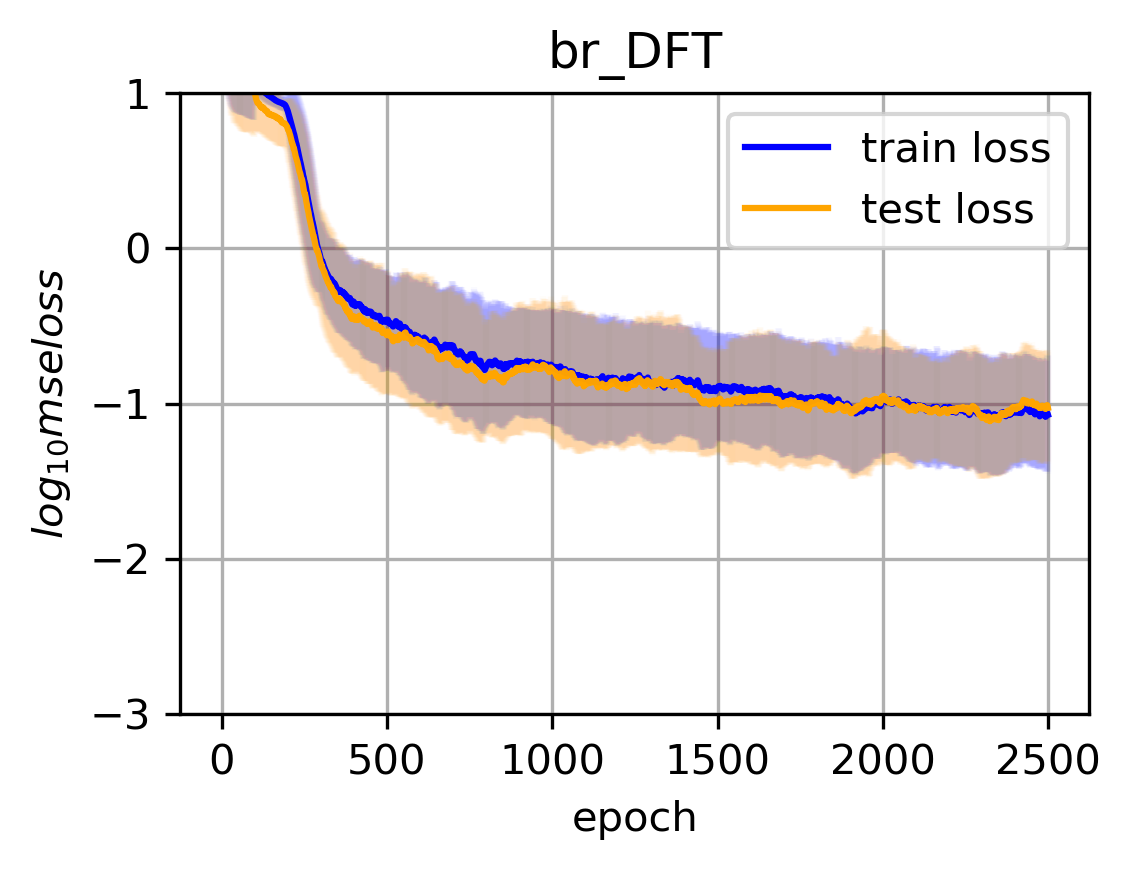

In [6]:
file_path = 'args.txt'  # Replace with the path to text file
ele, model_struc, epochs = load_config_values(file_path)
print(ele)

label_type = 'eda'

save_path = label_type +'/'

filepath_sobol = '/global/home/users/yifancui/delta-ml/dataset_v1.0/xyz/h2o_'+ele+'_sobol.xyz'
filepath_aimd = '/global/home/users/yifancui/delta-ml/dataset_v1.0/xyz/h2o_'+ele+'_aimd.xyz'
xyz_sobol = load_xyz(filepath_sobol)
xyz_aimd = load_xyz(filepath_aimd)
xyz = np.concatenate((xyz_sobol,xyz_aimd),axis=0)


##   SOBOL + AIMD

label = ['cls_elec','ct','mod_pauli','pol','disp']

E_eda_sobol = pd.read_csv('/global/home/users/yifancui/delta-ml/dataset_v1.0/eda_labels/h2o_'+ele+'_sobol.csv')[label]
E_eda_aimd = pd.read_csv('/global/home/users/yifancui/delta-ml/dataset_v1.0/eda_labels/h2o_'+ele+'_aimd.csv')[label]

if label_type == 'eda_aniso':
    E_aniso_sobol = pd.read_csv('/global/home/users/yifancui/delta-ml/dataset_v1.0/ff_aniso_labels/h2o_'+ele+'_sobol_ff_aniso.csv')[label]
    E_aniso_aimd = pd.read_csv('/global/home/users/yifancui/delta-ml/dataset_v1.0/ff_aniso_labels/h2o_'+ele+'_aimd_ff_aniso.csv')[label]
    E = np.concatenate((E_eda_sobol-E_aniso_sobol,E_eda_aimd-E_aniso_aimd),axis=0)
    label_type = 'DFT_aniso'

if label_type  == 'eda_dipole':
    E_dipole_sobol = pd.read_csv('/global/home/users/yifancui/delta-ml/dataset_v1.0/ff_dipole_labels/h2o_'+ele+'_sobol_ff_dipole.csv')[label]
    E_dipole_aimd = pd.read_csv('/global/home/users/yifancui/delta-ml/dataset_v1.0/ff_dipole_labels/h2o_'+ele+'_aimd_ff_dipole.csv')[label]
    E = np.concatenate((E_eda_sobol-E_dipole_sobol,E_eda_aimd-E_dipole_aimd),axis=0)
    label_type = 'DFT_dipole'
    
if label_type  == 'eda':
    label_type = 'DFT'
    E = np.concatenate((E_eda_sobol,E_eda_aimd),axis=0)
    
    
# select 5000 data points not included in the training set
size = len(xyz)
indices = list(range(size))
random.shuffle(indices)
train_indices = np.loadtxt(save_path+ 'train_indices.txt').tolist()
test_indices = list(set(indices)-set(train_indices))
random.shuffle(test_indices)
test_indices = test_indices[:10000]

xyz_test, E_test = xyz[test_indices], E[test_indices]
dist_all = np.array([dist(x) for x in xyz_test],dtype=np.float16)
dist_ion_water = dist_all[:,0,3]

hyb_test = hyb_n(xyz_test)
x_test = torch.tensor(hyb_test)
x_test = x_test.view(10000,16)
x_test = x_test.to(torch.float32)




device = torch.device('cpu')
model = torch.load(save_path+"best_model.pt",map_location=torch.device('cpu'))
model.to(device)
model.eval()
x_test = x_test.to(device)
output = model(x_test)
output_numpy = output.detach().numpy()

for i in range(5):
    plt.figure(figsize = (4,3),dpi=600)
    plt.scatter(dist_ion_water,output_numpy[:,i],s=0.3,alpha=0.7,label=r'$E_{delta-ml}$')
    plt.scatter(dist_ion_water,E_test[:,i],s=0.3,alpha=0.3,label=r'$E_{DFT}(kJ/mol)$')
    plt.xlabel(r'$r(\AA)$')
    plt.ylabel('E(kJ/mol)')
    plt.legend(loc='best',markerscale=6)
    
    if i ==0:
        plt.title(label_type+'_cls_elec_'+ele)
        plt.tight_layout()
        plt.savefig(save_path+ele+'_'+label_type+'_cls_elec_r.jpg')
    if i ==1:
        plt.title(label_type+'_ct_'+ele)
        plt.tight_layout()
        plt.savefig(save_path+ele+'_'+label_type+'_ct_r.jpg')
    if i ==2:
        plt.title(label_type+'_mod_pauli_'+ele)
        plt.tight_layout()
        plt.savefig(save_path+ele+'_'+label_type+'_mod_pauli_r.jpg')
    if i ==3:
        plt.title(label_type+'_pol_'+ele)
        plt.tight_layout()
        plt.savefig(save_path+ele+'_'+label_type+'_pol_r.jpg')
    if i ==4:
        plt.title(label_type+'_disp_'+ele)
        plt.tight_layout()
        plt.savefig(save_path+ele+'_'+label_type+'_disp_r.jpg')
        
        
plot_scatter(E_test[:,0],output_numpy[:,0],save_path,ele+'_'+label_type+'_cls_elec')
plot_scatter(E_test[:,1],output_numpy[:,1],save_path,ele+'_'+label_type+'_ct')
plot_scatter(E_test[:,2],output_numpy[:,2],save_path,ele+'_'+label_type+'_mod_pauli')
plot_scatter(E_test[:,3],output_numpy[:,3],save_path,ele+'_'+label_type+'_pol')
plot_scatter(E_test[:,4],output_numpy[:,4],save_path,ele+'_'+label_type+'_disp')
plot_box((E_test-output_numpy),save_path,ele,label_type)

E_test_eda = E_test
E_dml_eda = output_numpy


train_loss = np.loadtxt(save_path+'Train_mseloss_1.txt')
test_loss = np.loadtxt(save_path+'Test_mseloss_1.txt')
fig, axs = plt.subplots(1, 1,figsize=(4,3),dpi=300)

plot_mean_with_errorbars( np.arange(len(train_loss)),np.log10(train_loss), 100, 50,'blue',axs,label = 'train loss')
plot_mean_with_errorbars( np.arange(len(test_loss)),np.log10(test_loss), 100, 50,'orange',axs,label = 'test loss')

axs.set_xlabel('epoch')
axs.set_ylabel(r'$log_{10}mseloss$')
axs.set_title(ele+'_'+label_type)
axs.set_ylim(-3,1)
plt.tight_layout()
fig.savefig(save_path+ele+'_'+label_type+'_train_test.jpg')

# boxplot

In [7]:
eda_aniso = [E_test_eda_aniso[:,0]-E_dml_eda_aniso[:,0] , E_test_eda_aniso[:,1]-E_dml_eda_aniso[:,1], 
             E_test_eda_aniso[:,2]-E_dml_eda_aniso[:,2], E_test_eda_aniso[:,3]-E_dml_eda_aniso[:,3],
            E_test_eda_aniso[:,4]-E_dml_eda_aniso[:,4]]

eda_dipole = [E_test_eda_dipole[:,0]-E_dml_eda_dipole[:,0] , E_test_eda_dipole[:,1]-E_dml_eda_dipole[:,1], 
             E_test_eda_dipole[:,2]-E_dml_eda_dipole[:,2], E_test_eda_dipole[:,3]-E_dml_eda_dipole[:,3],
            E_test_eda_dipole[:,4]-E_dml_eda_dipole[:,4]]

eda = [E_test_eda[:,0]-E_dml_eda[:,0] , E_test_eda[:,1]-E_dml_eda[:,1], 
             E_test_eda[:,2]-E_dml_eda[:,2], E_test_eda[:,3]-E_dml_eda[:,3],
            E_test_eda[:,4]-E_dml_eda[:,4]]

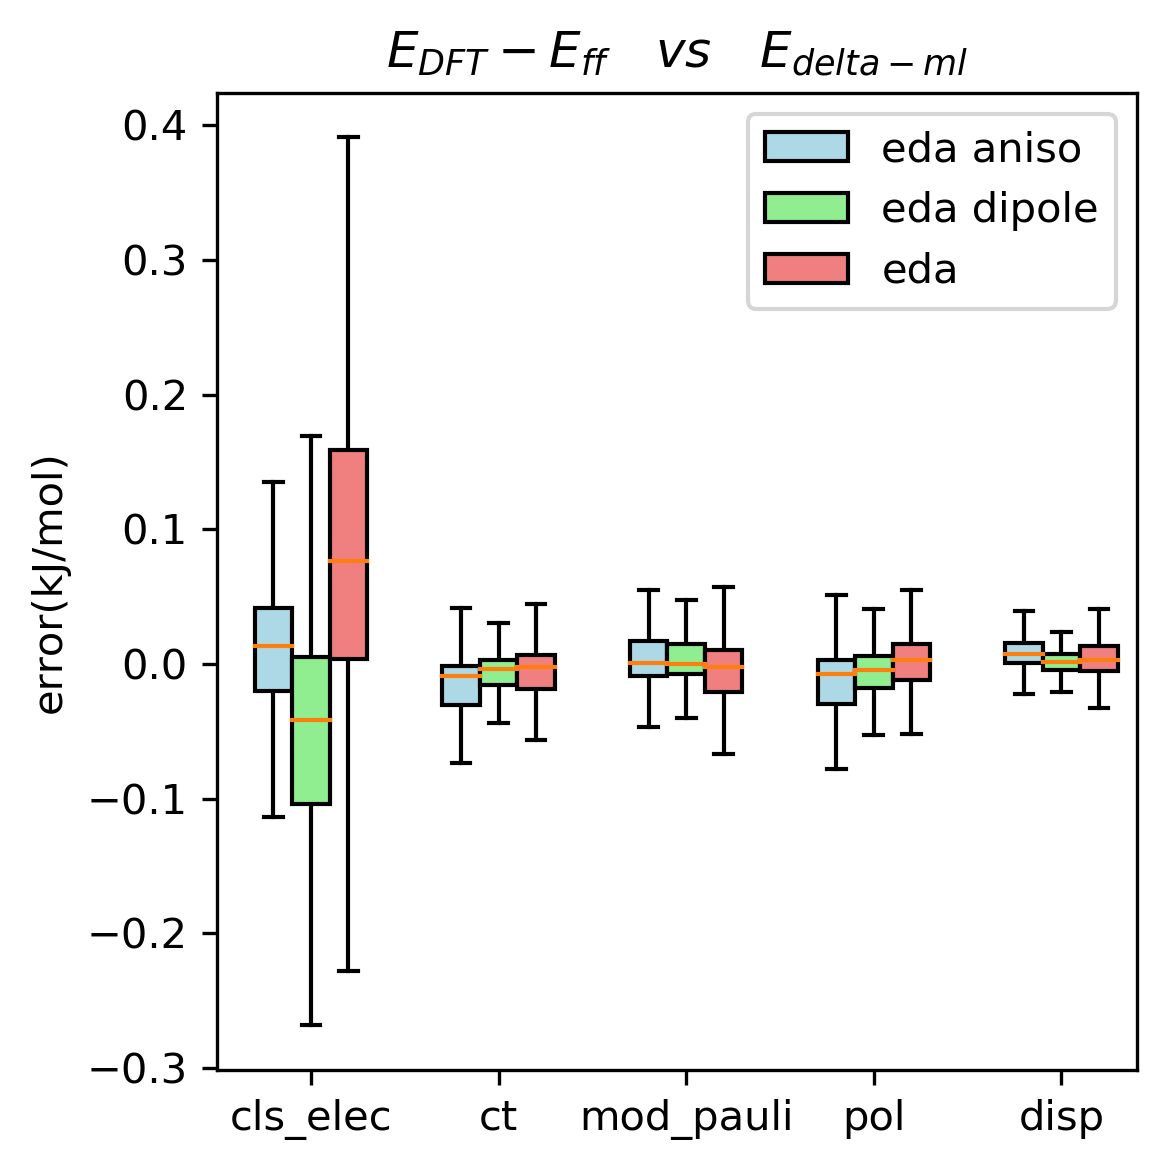

In [8]:
positions = [1, 5, 9, 13, 17]
width = 0.8

fig, ax = plt.subplots(figsize=(4, 4), dpi=300)

# Create grouped box plots
boxprops = dict(facecolor='lightblue')
bplot1 = ax.boxplot(eda_aniso, positions=[pos - width for pos in positions], widths=width, showfliers=False, patch_artist=True, boxprops=boxprops)

boxprops = dict(facecolor='lightgreen')
bplot2 = ax.boxplot(eda_dipole, positions=positions, widths=width, showfliers=False, patch_artist=True, boxprops=boxprops)

boxprops = dict(facecolor='lightcoral')
bplot3 = ax.boxplot(eda, positions=[pos + width for pos in positions], widths=width, showfliers=False, patch_artist=True, boxprops=boxprops)

#ax.set_xlabel('')
ax.set_ylabel('error(kJ/mol)')
ax.set_title(r'$E_{DFT}-E_{ff} \quad vs \quad E_{delta-ml}$')
ax.set_xticks(positions)
ax.set_xticklabels(label)
ax.legend([bplot1["boxes"][0], bplot2["boxes"][0], bplot3["boxes"][0]], ['eda aniso', 'eda dipole', 'eda'])

ax.set_xlim(-1, max(positions) + 2 * width)
plt.tight_layout()
plt.savefig(ele+'_errorbar.jpg')

plt.show()